# zBEAMS: Application to Strong Lensing 

Loading Packages
Importing Omega_k!=0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0


/mnt/users/hollowayp/python11_env_new/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/mnt/users/hollowayp/python11_env_new/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
Failed Check: 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


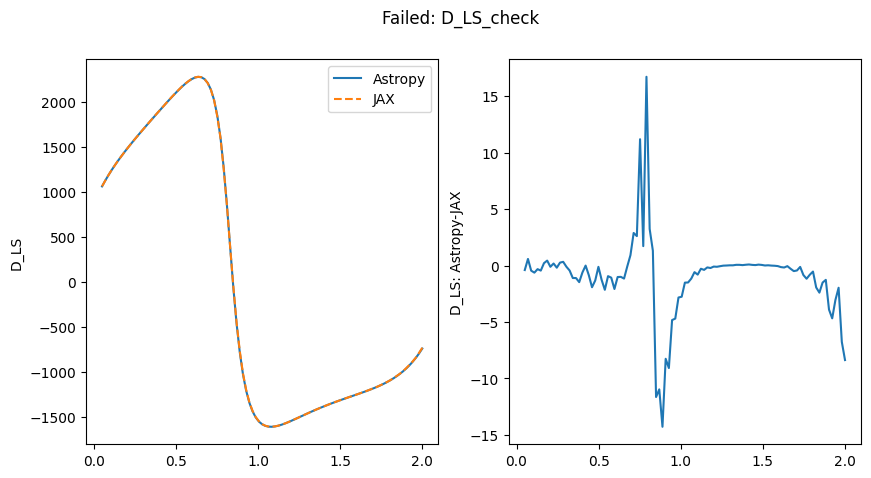

Failed Check (2) 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


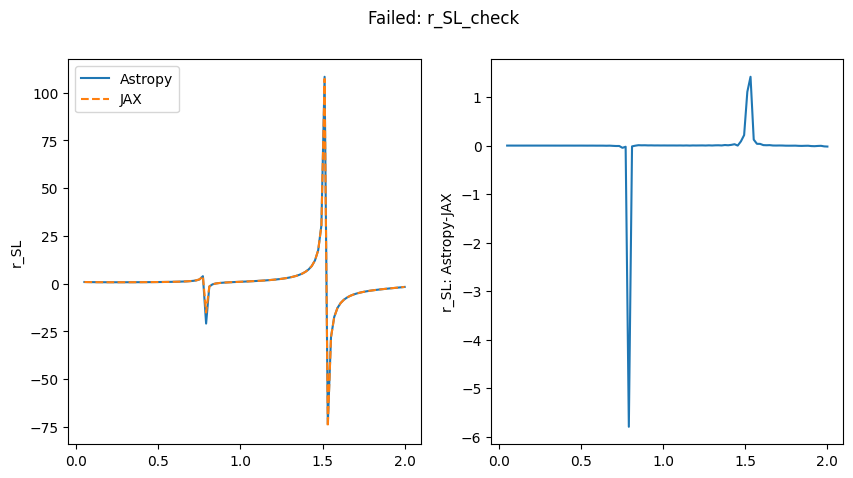

complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Importing Omega_k==0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0
complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Running Omega_k check


 69%|██████▉   | 162/234 [00:00<00:00, 707788.80it/s]


"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [2]:
print('Loading Packages')
from zbeamsfunctions_SL import likelihood_SL,likelihood_spec_contam_SL,likelihood_phot_contam_SL,likelihood_phot_SL,r_SL
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from zbeamsfunctions import mu_w,likelihood,likelihood_spec
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from Lenstronomy_Cosmology import Background, LensCosmo
from scipy.stats import multivariate_normal as MVN
from mcmcfunctions import mcmc,mcmc_spec,mcmc_phot
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC, HMCECS
from squash_walkers import squash_walkers
from scipy.stats import truncnorm, norm
from numpyro.diagnostics import summary
import matplotlib.patches as mpatches
from mcmcfunctions_SL import mcmc_SL
import matplotlib.lines as mlines
from cosmology_JAX import j_r_SL
from jax import random,grad, jit
import matplotlib.pyplot as pl
from subprocess import run
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import scipy.sparse
import pandas as pd
import arviz as az
import numpy as np
import importlib
import numpyro
import corner
import emcee
import glob
import sys
import jax

try:importlib.reload(sys.modules['mcmcfunctions_SL'])
except Exception as ex: print(f'Cannot reload: {ex}')

from mcmcfunctions_SL import mcmc_SL

Om_fid = 0.3;Ode_fid = 0.7;H0_fid = 70;w_fid = -1.0;wa_fid=0

cosmo_type = 'wCDM'
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''



In [ ]:
import sys
from importlib import reload  # Python 3.4+
reload(sys.modules['mcmcfunctions_SL_JAX'])
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as pl
from zbeamsfunctions_SL import likelihood_phot_SL
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

def phot_likelihood_check():
    '''
    A function to verify if the likelihoods for the emcee and JAX MCMC methods are the same, in the case of a photometric but
    *uncontmainated* sample. 
    Results:
    The results are the same except for w and wa. These return nan's for certain values of w and wa, and differ from the emcee
    likelihood just before this. This may be due to the particular selection of cosmology parameters being unphysical (it 
    seems ok with OM=0.3, but not if OM=0). 
    '''

    likelihood_dict_default = {'H0':70,'OM':0, 'Ok':0, # The default is Om=0 and Ok = 0. This is so when one of them is updated
                               # in likelihood_dict below, it doesn't require Ode to be >1. Otherwise if I let Om or Ok vary between
                               # [0,1] and the other (Ok or Om) is non-zero by default, it would require Ode to be >1.
                                'w':-1,'wa':0,
                                'r_obs':jnp.array([1]),'sigma_r_obs':jnp.array([1]),
                                'zL':1,'zS':2,
                                'zL_obs':jnp.array([1]),'zS_obs':jnp.array([2]),
                                'zL_sigma':0.1,'zS_sigma':0.2,
                                'mu_zL_g_L':1.1,'mu_zS_g_L':2.2,
                                'sigma_zL_g_L':0.1,'sigma_zS_g_L':0.1,
                                'sigma_01_g_L':0,'sigma_10_g_L':0}
    def jax_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        return j_likelihood_SL(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
            cosmo_type='wCDM',
            photometric=True,
            contaminated=False,
            H0=likelihood_dict['H0'],
            key=PRNGKey(0),
            likelihood_check=True,
            likelihood_dict = likelihood_dict,
            cov_redshift=False)[0]

    def emcee_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        likelihood_dict['Ode'] = 1-(likelihood_dict['OM']+likelihood_dict['Ok']) #Renaming keys to the correct emcee argument names
        likelihood_dict['si_00_g_L'] = likelihood_dict['sigma_zL_g_L']
        likelihood_dict['si_11_g_L'] = likelihood_dict['sigma_zS_g_L']
        likelihood_dict['sigma_zL_obs'] = likelihood_dict['zL_sigma']
        likelihood_dict['sigma_zS_obs'] = likelihood_dict['zS_sigma']
        likelihood_dict['sigma_r_obs_1'] = likelihood_dict['sigma_r_obs']
        likelihood_dict['zL'] = np.array([likelihood_dict['zL']])
        likelihood_dict['zS'] = np.array([likelihood_dict['zS']])
        for k_i in ['Ok','sigma_zL_g_L','sigma_zS_g_L',
                    'zL_sigma','zS_sigma','sigma_r_obs',
                    'sigma_10_g_L','sigma_01_g_L']: #Removing redundant keys
            likelihood_dict.pop(k_i, None)
        return likelihood_phot_SL(**likelihood_dict,cosmo_type='wCDM')

    param_vary_dict = {
                        'zL':np.linspace(0.1,1,10),
                        'zS':np.linspace(1,2,10),
                        'zL_obs':np.linspace(0.1,1,10),
                        'zS_obs':np.linspace(1,2,10),
                        'r_obs':np.linspace(0,2,10),
                        'sigma_r_obs':np.linspace(0.5,5,10),
                        'zL_sigma':np.linspace(0.5,5,10),
                        'zS_sigma':np.linspace(0.5,5,10),
                        'OM':np.linspace(0,1,10),
                        'Ok':np.linspace(0,1,10),
                        'w':np.linspace(-6,4,100),
                        'wa':np.linspace(-3,1,100),
                        'mu_zL_g_L':np.linspace(0.5,5,10),
                        'mu_zS_g_L':np.linspace(0.5,5,10),
                        'sigma_zL_g_L':np.linspace(0.5,5,10),
                        'sigma_zS_g_L':np.linspace(0.5,5,10)
                        }
    for param_i in param_vary_dict.keys():
        L_jax = np.vectorize(jax_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        L_emcee = np.vectorize(emcee_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        try:
            assert (abs((L_jax-L_emcee)/L_jax)<0.01).all()
        except: 
            print(f'ASSERTION ERROR: {param_i}')
            pl.plot(param_vary_dict[param_i],L_jax,label='JAX')
            pl.plot(param_vary_dict[param_i],L_emcee,'--',label='emcee')
            pl.xlabel(param_i)
            pl.legend()
            pl.show()
    
phot_likelihood_check()

In [ ]:
MCMC_JAX_i = run_MCMC(photometric = False,
            contaminated = False,
            cosmo_type = 'LambdaCDM',
            zL_obs = jnp.array(db_in['zL_obs']),
            zS_obs = jnp.array(db_in['zS_obs']),
            sigma_zL_obs = jnp.array(db_in['sigma_zL_obs']),
            sigma_zS_obs = jnp.array(db_in['sigma_zS_obs']),
            r_obs = jnp.array(db_in['r_obs_contam']),
            sigma_r_obs = jnp.array(db_in['sigma_r_obs']),
            sigma_r_obs_2 = 1000*jnp.max(jnp.array(db_in['sigma_r_obs'])),
            P_tau = 0.99*jnp.array(db_in['P_tau']),
            num_warmup = 1000,
            num_samples = 1000,
            num_chains = 2,
            H0=70,
            target_accept_prob=0.8,
            cov_redshift=False)

#### Generate Databases

In [33]:
sys.path.append('/mnt/zfsusers/hollowayp/paltas')
from Load_LensPop_Euclid_db import db_LensPop_Euclid
db_LensPop_Euclid

,zL,zS,tE,sig_v,q_lens_flat,Re_lens,VIS_lens,xs,ys,q_source_flat,PA_source,Re_source,VIS_source,mu_s,VIS_see,VIS_SNR_sub,e1_source,e2_source
0,0.280,0.821,1.10,251.1,0.364,1.20,17.35,-0.35,-0.04,0.592,175.6,0.26,24.80,6.39,0.17,25.89,0.253265,-0.039207
1,0.722,1.264,0.36,191.3,0.681,0.34,22.02,-0.15,0.08,0.588,102.3,0.10,25.54,4.26,0.17,28.09,-0.235898,-0.108002
2,0.572,1.065,0.23,142.8,0.543,0.30,22.19,-0.01,0.03,0.643,116.5,0.10,26.04,6.25,0.17,27.31,-0.130766,-0.173532
3,0.454,1.831,0.48,160.1,0.730,0.45,20.78,-0.23,-0.05,0.694,92.4,0.11,24.10,3.96,0.17,76.17,-0.180004,-0.015115
4,0.804,1.466,0.32,179.5,0.568,0.24,22.65,-0.02,0.24,0.711,55.9,0.12,24.83,3.57,0.17,48.62,-0.062727,0.156828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,0.780,3.766,1.45,287.6,0.831,0.56,20.40,-0.33,-0.06,0.483,170.7,0.02,26.65,7.28,0.17,30.22,0.330409,-0.111195
15986,1.327,2.817,0.52,227.3,0.732,0.49,24.76,-0.05,-0.32,0.896,157.0,0.22,25.20,3.66,0.17,24.59,0.038104,-0.039457
15987,0.694,1.749,1.62,341.8,0.715,0.98,18.85,0.04,-0.05,0.737,12.2,0.53,24.71,8.85,0.17,31.98,0.137887,0.062548
15988,0.772,2.223,0.74,224.6,0.501,0.45,21.52,-0.11,0.21,0.832,60.0,0.20,24.48,6.18,0.17,63.90,-0.045852,0.079417


In [ ]:
db_LensPop_Euclid['zL']

In [ ]:
def r_obs_func(tE,vel_disp): #In arcsec and km/s
    tE = tE*(np.pi/180)*(1/3600) #Convert to radians
    vel_disp = vel_disp*1000 #convert to m/s
    c = 299792458 #m/s
    return (c**2)*tE/(4*np.pi*vel_disp**2)

from generate_catalogue_databases import generate_catalogue_databases

N_lens = 7500
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in np.linspace(0.5,1,26):
    N_obs_i = int(N_lens/true_lens_frac)
    generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=N_obs_i,
                             true_lens_frac=true_lens_frac,
                             cosmo_type='wCDM',
                             Om_fid=Om_fid,
                             Ode_fid=Ode_fid,
                             H0_fid=H0_fid,
                             w_fid=w_fid,
                             wa_fid=wa_fid,
                             verbose=False,
                             absolute_error = 0.02,
                             db_name = 'LensPop_Euclid')

In [ ]:
#zL_obs=db_in['zL_obs'];zS_obs=db_in['zS_obs'];r_obs=db_in['r_obs'];sigma_r_obs=db_in['sigma_r_obs'] #Making these up!!!

from generate_databases import generate_databases

N_lens = 1000
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in np.linspace(0.5,1,60):
    N_obs_i = int(N_lens/true_lens_frac)
    generate_databases(N_obs=N_obs_i,#int(N_obs_i),
                       true_lens_frac=true_lens_frac,#N_lens/N_obs_i,
                       #Percentage_error=5, This causes errors in the MCMC as the errors become very small for low redshift or r_obs.
                       absolute_error=0.01,
                       cosmo_type='wCDM',
                       Om_fid=Om_fid,
                       Ode_fid=Ode_fid,
                       H0_fid=H0_fid,
                       w_fid=w_fid,
                       wa_fid=wa_fid,
                       verbose=False)

'''#Note, need the backslash after VARIABLE (in the addqueue...)
print('for VARIABLE in {50..100..2}
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_100_samples_$VARIABLE\_true_cosmo_.csv True False wCDM 1000
done

for VARIABLE in 2 4 8 16 32 64 128 256 512 1024
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_$VARIABLE\_samples_100_true.csv False False wCDM 1000
done
'''

In [ ]:
#Spectroscopic no contamination: python3.11-725589.out and python3.11-725590.out
!addqueue -c '1hr' -m 2 -n 1x4 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 10000 
#Spectroscopic 20% Contamination: python3.11-725591.out and python3.11-725592.out
!addqueue -c '1hr' -m 2 -n 1x4 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True False wCDM 1000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True False wCDM 10000 
#Photometric, no contamination: python3.11-725593.out
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#Photometric, with contamination: python3.11-725594.out
!addqueue -c '2hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True True wCDM 2000 2
#100k sample: python3.11-725595.out
!addqueue -c '12hr' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 1


#### Run on Glamdring

In [ ]:
#Photometric, no contamination: JAX: python3.11-727129.out emcee: python3.11-727130.out (=> OOM)
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 10000 
#Photometric, no contamination: JAX with uniform redshift prior: python3.11-727158.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#Photometric, no contamination: JAX with Gaussian noise on parent distribution: python3.11-727310.out, python3.11-727311.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_512_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#And with more systems: python3.11-727312.out, python3.11-727313.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_4096_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#Having fixed covariance bug: python3.11-727623.out => OOM. python3.11-727668.out
#!addqueue -c '1hr' -m 4 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200
#And trying asserting zL<zS: python3.11-727624.out => Still bugged.
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#Adding full covariance matrix for the redshift parent distribution: python3.11-727625.out => OOM. python3.11-727662.out => Didn't converge
#!addqueue -c '1hr' -m 4 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.8 True
#Trying again with more samples and with a GPU (9hr, none converged): python3.11-727681.out
#!addqueue -c '1hr' -m 4 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_4096_samples_100_true_cosmo_wCDM.csv False True wCDM 1500 4 1500 0.9 True
#Trying again with even more samples and with a GPU: python3.11-727767.out (6hr, none converged)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 4 1000 0.8 True
#Trying again, with sigma_01 and sigma_10 now in the range [0.01,1], rather than [0.1,2] (as true sigma_01 and sigma_10 were ~0.1) 
#and with sigma_00 and sigma_11 now in range [0.1,1], to make the MCMC easier: python3.11-728103.out (15min, none converged)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 4 1000 0.8 True
#Now also with sigma_00 and sigma__11 in range [0.01,1]. Making it much easier by assuming LambdaCDM and assuming diagonal covariance: python3.11-728165.out (3hr, none converged)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv False True LambdaCDM 1500 4 1500 0.99 False
'''=> Has to be something with the sigmas? Too big/small?'''
#Double checking for generic bug: python3.11-728216.out (STILL didn't converge)
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1500 4 1500 0.99 False
#And again: python3.11-728230.out/python3.11-728231.out (Still didn't converge)
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1500 4 1500 0.99 False
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1000 2 1000 0.8 False
#Now trying with 10% error, as the redshift errors are really tiny when just 1%: Worked!! 
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1000 2 1000 0.8 False
#Now trying with more runs, as it didn't get the right answer:python3.11-728233.out
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 2000 4 1000 0.99 False
#Giving more data, as still didn't get right answer: (didn't converge)
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 2000 4 1000 0.99 False
#Perhaps that isn't surprising, as asserting there is no error in redshifts
#Now trying assuming photo-z's (Finally converged! Still a small bias): python3.11-728236.out 
#Small bias couldn't just be due to random scatter in the walkers:
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True LambdaCDM 2000 4 1000 0.8 False
#Now reasserting zS>zL, and with more complex cosmology: python3.11-728490.out (Bugged - no valid samples)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 False
#Now also allowing non-diagonal covariance again: python3.11-728491.out (Bugged - no valid samples)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 True
#Removing assertion zS>zL and running again: python3.11-728493.out (converged!)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 False
#... as above: python3.11-728494.out (converged!)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 True
#Running the same as above, but with more datapoints to see if that removes bias: python3.11-728900.out
for c_i in range(0): #python3.11-728977.out => python3.11-728984.out
    run("addqueue -c '10hr' -m 3 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 1 1000 0.8 True",
    shell=True)
#Trying with HMCECS: python3.11-731027.out => Hadn't yet converged on a solution.
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 True
#Trying again, but splitting subsample into 1 blocks (i.e. not splitting it): python3.11-731174.out. Saved to ...JAX_chains_3.csv => Didn't give correct result
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 1000 0.8 True
#Trying again, with longer warmup: python3.11-731175.out. Saved to....JAX_chains_4.csv => Didn't give correct result
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#Trying again (speed test) for larger sample size: python3.11-731176.out => Would've taken ages: 14hrs/chain
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#Now subsampling (nearly) all the calculations, to increase speed for many samples: python3.11-731180.out => Saved to ...JAX_Chains_16.csv. Didn't give correct result.
#!addqueue -c '10hr' -m 14 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#And again, with subsample size =1000, with smaller sample (1024):python3.11-731612.out => Gave wrong answer.
#!addqueue -c '10hr' -m 14 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#Trying uncontaminated+spectroscopic, with HMCECS: python3.11-732076.out => Noteably didn't give the right answer.
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 True
#Trying again without redshift covariances: python3.11-732081.out => Didn't converge to correct result
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Trying again with more warmup: python3.11-732082.out => Didn't converge to correct result.
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 10000 2 10000 0.9 True
#Trying again with more data: python3.11-732083.out
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_32768_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 True
#Double checking the original worked: python3.11-732188.out. IT DIDN'T. 
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Removing the Key: python3.11-732190.out: Bugged.
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Making Ok deterministic: python3.11-732193.out
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Adding in a key at the start: python3.11-732194.out => Didn't converge
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
'''
==> Problem was caused by the fact the errors in the input database were too small (e.g. using 5% of the redshift or r_obs number)  
produced very small errors when the redshift or r_obs was small. This then made the MCMC converge to the wrong value, perhaps due to 
floating point errors?
'''
#Perhaps change to uniform distribution in variance? Though wouldn't help the spectroscopic/photometric case...
#Trying with updated input database and small absolute errors (0.01): python3.11-732348.out => One (of 4) chains converged.
#!addqueue -c '5hr' -m 14 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 4 1000 0.9 False
#As above, with just one chain and short samping number, to judge when to stop warmup: python3.11-732351.out
#!addqueue -c '5hr' -m 14 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 100 1 1000 0.9 False

#Trying with Euclid Lenspop Database: Bugged as sanmple size (1000) was <=subsample size(1000)
#!addqueue -c '5hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_1000_samples_100_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.9 False
#Trying again with larger sample:
#!addqueue -c '5hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.9 False  
#And with even larger sample (8192):
!addqueue -c '5hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.9 False  

#Evaluating whether increased redshift error causes bias: 12710.out=>12712.out:
addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 10 1000 0.9 False  
addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 10 1000 0.9 False  
addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 10 1000 0.9 False  


In [48]:
from generate_catalogue_databases import generate_catalogue_databases
#Making Euclid database with larger error:
catalogue_db_dict = {'true_lens_frac':1,'cosmo_type':'wCDM','Om_fid':Om_fid,'Ode_fid':Ode_fid,'H0_fid':H0_fid,
                    'w_fid':w_fid,'wa_fid':wa_fid,'verbose':False}
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=7500,
                             **catalogue_db_dict,
                             absolute_error = 0.02,
                             db_name = 'LensPop_Euclid')
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=3750,
                             **catalogue_db_dict,
                             absolute_error = 0.1,
                             db_name = 'LensPop_Euclid')
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=7500,
                             **catalogue_db_dict,
                             absolute_error = 0.1,
                             db_name = 'LensPop_Euclid')
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=15000,
                             **catalogue_db_dict,
                             absolute_error = 0.1,
                             db_name = 'LensPop_Euclid')

db_7500_precise = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv')
db_3750_imprec = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p1abs_3750_samples_100_true_cosmo_wCDM.csv')
db_7500_imprec = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv')
db_15000_imprec = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p1abs_15000_samples_100_true_cosmo_wCDM.csv')

db_7500_precise.to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500}.csv')
pd.concat([db_7500_precise,db_3750_imprec],ignore_index=True).to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500+3750}.csv')
pd.concat([db_7500_precise,db_7500_imprec],ignore_index=True).to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500+7500}.csv')
pd.concat([db_7500_precise,db_15000_imprec],ignore_index=True).to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500+15000}.csv')

#Testing how a larger sample including larger errors affects any bias 12700.out=>12703.out:
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_7500.csv False True wCDM 1000 10 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_11250.csv False True wCDM 1000 10 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_15000.csv False True wCDM 1000 10 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_22500.csv False True wCDM 1000 10 1000 0.9 False  
#And again with fewer walkers (just for speed) 12740.out=>12743.out:
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_7500.csv False True wCDM 1000 5 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_11250.csv False True wCDM 1000 5 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_15000.csv False True wCDM 1000 5 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_22500.csv False True wCDM 1000 5 1000 0.9 False  


Generating sample of 7500 systems, of which 100% are true lenses with 0.02 absolute measurement error in a wCDM cosmology. This has parameters Om:0.3, Ode:0.7, H0:70, w:-1.0 and wa:0
./databases/LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv
Generating sample of 3750 systems, of which 100% are true lenses with 0.1 absolute measurement error in a wCDM cosmology. This has parameters Om:0.3, Ode:0.7, H0:70, w:-1.0 and wa:0
./databases/LensPop_Euclid_Gaussian_noise_0p1abs_3750_samples_100_true_cosmo_wCDM.csv
Generating sample of 7500 systems, of which 100% are true lenses with 0.1 absolute measurement error in a wCDM cosmology. This has parameters Om:0.3, Ode:0.7, H0:70, w:-1.0 and wa:0
./databases/LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv
Generating sample of 15000 systems, of which 100% are true lenses with 0.1 absolute measurement error in a wCDM cosmology. This has parameters Om:0.3, Ode:0.7, H0:70, w:-1.0 and wa:0
./databases

In [ ]:
def sigma_r_obs_func(r_obs,theta,sigma_theta,vel_disp,sigma_vel_disp):
    A = (sigma_theta/theta)**2
    B = (2*sigma_vel_disp/vel_disp)**2
    return r_obs*np.sqrt(A+B)

sigma_r_obs_func(r_obs_func(db_LensPop_Euclid['tE'],
                            db_LensPop_Euclid['sig_v']),
            theta=db_LensPop_Euclid['tE'],
            sigma_theta=0.01,
            vel_disp= db_LensPop_Euclid['sig_v'],
            sigma_vel_disp=10).median()#rougly 0.05 for vel_disp error ~10km/s and tE error of 0.01"


: 

In [ ]:
import subprocess
N_lens = 1000
'''To vary lens fraction by factors of 2:'''
for N_obs_i in []:#np.linspace(1000,10000,10):
    subprocess.run("addqueue -c '1hr' -m 4 -n 1x2 -s -q planet "+\
            f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 1000 10 1000 0.6 False",
            shell=True)
#1000 true systems, 0.01 r-error. 732428.out=>python3.11-732437.out => Converged but some chains converged to wrong number.
#As above, changing target_accept_prob from 0.99 to 0.6 to encourage larger step size.732447.out=>732456.out => Not a clear success/failure.

'''To vary lens fraction linearly:'''
for true_lens_frac in []:#np.linspace(0.5,1,60):
    N_obs_i = int(N_lens/true_lens_frac)
    subprocess.run("addqueue -c '1hr' -m 4 -n 1x2 -s -q planet "+\
            f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 2000 50 2000 0.8 False",
            shell=True)
#1000 systems, 0.01 r-error. python3.11-732461.out=>python3.11-732466.out
#Running with more intervals (60): 732486.out=>732598.out
#Running with more chains and more samples 732617.out=>732676.out

#Now with the 0.99*P_tau factor removed in run_zBEAMS.py. 
#With 0.05 error on r_obs, and r_obs calculated using Om=0.3, Ode=0.7, rather than directly from the redshifts/vel_disps.
#=> 
#Trying again with larger subsample size (5000) to give greater consistency in results: Substantial improvement. Much more consistent results between chains and across contamination range.
#And again with EVEN larger subsample size (7500), as this seemed to work:
N_lens = 7500
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in np.linspace(0.5,1,26):
    N_obs_i = int(N_lens/true_lens_frac)
    print("addqueue -c '1hr' -m 4 -n 1x2 -s -q berg "+\
            f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 1000 10 2000 0.8 False")
    
    

In [ ]:
#Trying what happens if have contaminated sample but don't allow for it in zBEAMS:
#addqueue -c '1hr' -m 4 -n 1x2 -s -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_9375_samples_80_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.8 False


In [ ]:
'''
Question: Does the GPU thing run faster if I give it more cores (within 1 node)?
Answer: Giving 20GB on 1 node + 1 core was very slow on gpulong_5.
Variable improvement for giving 4x more cores in the same node (1x4 vs 1x1) => Wasn't 4x faster anyway.
-n 1x4 -m 5:  4m20, 7m, 5m
-n 1x1 -m 5:  5m30, 4m, 4m30
-n 1x1 -m 20: 5m20, 3m30, 4m

'''
#!addqueue -c '1hr' -m 5 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
#!addqueue -c '1hr' -m 5 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
#!addqueue -c '1hr' -m 20 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5

In [ ]:
'''
To get 100k samples, ran this:
addqueue -c '50min' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 2
Output here: /mnt/zfsusers/hollowayp/zBEAMS/python3.11-725389.out
Ran first chain then ran out of memory when starting the second.
'''

#### Investigating HMCECS Kwargs

In [ ]:
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import HMCECS, MCMC, NUTS

def model(data,subsample_size):
    x = numpyro.sample("x", dist.Normal(0, 1))
    with numpyro.plate("N", data.shape[0], subsample_size=subsample_size):
        batch = numpyro.subsample(data, event_dim=0)
        numpyro.sample("obs", dist.Normal(x, 1), obs=batch)

data = random.normal(random.PRNGKey(0), (10000,)) + 1

In [ ]:
num_block_list = [1,10,100]
subsample_size_list = [100,500,1000,5000] #Large subsample size takes ages!
fig,ax = pl.subplots(len(num_block_list),len(subsample_size_list),
                    figsize=(5*len(subsample_size_list),5*len(num_block_list)))
for x_i,num_blocks_i in enumerate(num_block_list):
    for y_i,subsample_size_i in enumerate(subsample_size_list):
        kernel = HMCECS(NUTS(model), num_blocks=num_blocks_i)
        mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000,num_chains=10)
        mcmc.run(random.PRNGKey(0), data, subsample_size_i)
        samples = mcmc.get_samples(True)["x"]
        ax[x_i,y_i].errorbar(np.arange(samples.shape[0]),y=samples.mean(axis=1),
                    yerr=samples.std(axis=1),fmt='.')
        ax[x_i,y_i].set_ylim(0.9,1.1)
        ax[x_i,y_i].set_title(f'Blocks: {num_blocks_i}, Subsample size: {subsample_size_i}')
pl.tight_layout()
pl.show()

### Testing jax_likelihood_SL

In [ ]:
from importlib import reload
from mcmcfunctions_SL_JAX import j_likelihood_SL
reload(sys.modules['mcmcfunctions_SL_JAX'])
from mcmcfunctions_SL_JAX import j_likelihood_SL
import time

def run_MCMC(photometric,contaminated,cosmo_type,
            zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,
            r_obs,sigma_r_obs,sigma_r_obs_2,P_tau,
            num_warmup = 200,num_samples=1000,num_chains=2,H0=np.nan,target_accept_prob=0.8,cov_redshift=False):
    model_args = {'zL_obs':zL_obs,'zS_obs':zS_obs,
                'sigma_zL_obs':sigma_zL_obs,'sigma_zS_obs':sigma_zS_obs,
                'r_obs':r_obs,'sigma_r_obs':sigma_r_obs,'sigma_r_obs_2':sigma_r_obs_2,
                'P_tau':P_tau,
                'cosmo_type':cosmo_type,
                'photometric':photometric,'contaminated':contaminated,
                'H0':H0,
                'cov_redshift':cov_redshift}
    key = jax.random.PRNGKey(0)
    print(f'Target Accept Prob: {target_accept_prob}')
    st = time.time()
    j_likelihood_SL(**model_args,key=key,early_return=True)
    mt=time.time()
    j_likelihood_SL(**model_args,key=key,early_return=True)
    et=time.time()
    print('Uncompiled time',mt-st)
    print('Compiled time',et-mt)
    inner_kernel = NUTS(model = j_likelihood_SL,target_accept_prob = target_accept_prob)
    outer_kernel = HMCECS(inner_kernel, num_blocks=1)
    sampler_0 = MCMC(outer_kernel,
                    num_warmup=num_warmup,
                    num_samples=num_samples,
                    num_chains=num_chains,
                    progress_bar=True)
    sampler_0.warmup(key,**model_args,collect_warmup=True)
    warmup_samples = sampler_0.get_samples(True)
    from JAX_samples_to_dict import JAX_samples_to_dict
    warmup_dict = JAX_samples_to_dict(sampler_0,separate_keys=True,cosmo_type=cosmo_type).copy()
    db_JAX_warmup = pd.DataFrame(warmup_dict)
    fig,ax = pl.subplots(1,5,figsize=(25,5))
    plot_JAX_chains(db_JAX_warmup,fig=fig,ax=ax)
    #return warmup_samples
    sampler_0.run(key,**model_args,key=None)
    sampler_dict = JAX_samples_to_dict(sampler_0,separate_keys=True,cosmo_type=cosmo_type)
    db_JAX_samples = pd.DataFrame(sampler_dict)
    plot_JAX_chains(db_JAX_samples,fig=fig,ax=ax,zero=num_warmup)
    pl.show()
    return sampler_0
#32768
db_in = pd.read_csv('./databases/Gaussian_noise_0p01abs_1024_samples_100_true_cosmo_wCDM.csv')
sampler_0 = run_MCMC(photometric=False,contaminated=False,cosmo_type='wCDM',
            **{elem:jnp.array(db_in[elem]) for elem in ['sigma_zL_obs','sigma_zS_obs','sigma_r_obs','P_tau']},
            r_obs=jnp.array(db_in['r_obs_contam']),
            zL_obs = jnp.array(db_in['zL_true']),
            zS_obs = jnp.array(db_in['zS_true']),
            sigma_r_obs_2=1000*np.max(db_in['sigma_r_obs']),
            num_warmup = 100,num_samples=100,num_chains=5,H0=70,
            target_accept_prob=0.8,cov_redshift=False)

#Gives much closer result when use FlatLambdaCDM rather than LambdaCDM, but still slightly biased
#Converges to entirely the wrong number if make absolute error 0.1 rather than 0.05 (even with FlatLambdaCDM?)
#BUG: Was using zL, zS values which had gaussian errors in them, but then asserting (via photometric=False), that the 
#redshifts were 100% accurate.

In [ ]:
JAX_chains,db_in = locate_latest_chains('abs',0.01,8192,Perc_true=100,
                                        contamination_str='False',photometric_str='True',
                                        cosmo_type_str='wCDM',JAX=True,
                                        cosmo_db_str='wCDM',return_db=True,
                                        list_of_file_indx= [],
                                        warmup=True)

#SL_orig_Gaussian_noise_0p05abs_32768_samples_100_true_cosmo_wCDM.csv_ph_False_con_False_wCDM_JAX_chains_0_warmup.csv


In [ ]:
plot_JAX_chains(JAX_chains)

### Speed Testing

In [ ]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
from scipy.stats import norm
import jax.numpy as jnp
import numpyro
import jax
import time
from jax import local_device_count,default_backend,devices
print('COMPS',local_device_count(),default_backend(),devices()) #= 1 gpu [cuda(id=0)] when run on GPU.

def normpdf(x, mean, sd):
    var = (sd)**2
    return jnp.log(((2*jnp.pi*var)**-0.5)*(jnp.exp(-(x-(mean))**2/(2*var))))

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(normpdf)(x,mu,sigma)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = MCMC(
        NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=False)
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

st=time.time()
N_iter=2
for i in range(N_iter):
    a=run_MCMC()
t_iter=(time.time()-st)/N_iter
print(f"{t_iter} per iteration") #3.5s for GPU, 2s for CPU.

In [ ]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import numpyro
import jax
from scipy.stats import norm
import time

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(dist.Normal)(mu,sigma).log_prob(x)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = MCMC(
        NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=True,
        chain_method='parallel')
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

# st=time.time()
# N_iter=10
# for i in range(N_iter):
#     a=run_MCMC()
# t_iter=(time.time()-st)/N_iter
# print(f"{t_iter} per iteration")

a=run_MCMC()

#### Toy Model for Testing Covariance

In [172]:
import jax.numpy as jnp
from numpyro import distributions as dist,infer
from numpyro.infer import MCMC,NUTS,HMC,HMCECS
from scipy.stats import norm
import jax
import numpyro
def j_r_SL_flat_test(z,o):
    return o*(z**2)

def j_likelihood_SL_toy(zL_obs,zL_sigma,r_obs,sigma_r_obs):
        key = jax.random.PRNGKey(0)
        O = jnp.squeeze(numpyro.sample("OM", dist.Uniform(0,1),sample_shape=(1,),rng_key=key))
        zL = numpyro.sample('zL',dist.Normal(jnp.array(zL_obs),zL_sigma),sample_shape=(1,),rng_key=key).flatten()
        O12 = 0*jnp.ones(zL.shape)
        r_theory = j_r_SL_flat_test(zL,O)
        # cov_mat = jnp.array([[zL_sigma**2,O12**2],
        #                     [O12**2,sigma_r_obs**2]]).T
        # loc_obs = jnp.array([zL_obs,r_obs]).T
        # loc = jnp.array([zL,r_theory]).T
        # prob_0 = dist.MultivariateNormal(loc = loc_obs,
        #                     covariance_matrix = cov_mat).log_prob(loc)
        prob_1 = dist.Normal(r_obs, sigma_r_obs).log_prob(r_theory)
        prob_2 = dist.Normal(zL_obs, zL_sigma).log_prob(zL)
        L = numpyro.factor("Likelihood",prob_1+prob_2)

N_obs = 1000
O_test = 0.3
zL_true_test = jnp.array(norm(20,3).rvs(size=N_obs))
zL_sigma_test = 1.5*jnp.ones(N_obs)
zL_obs_test = norm(zL_true_test,zL_sigma_test).rvs()
r_sigma_test = 5*jnp.ones(N_obs)
r_obs_test = jnp.array(norm(j_r_SL_flat_test(zL_true_test,O_test),r_sigma_test).rvs())

def run_MCMC_test():
    key = jax.random.PRNGKey(0)
    sampler_0 = MCMC(
        NUTS(j_likelihood_SL_toy),
        num_warmup=1000,
        num_samples=1000,
        num_chains=5,
        progress_bar=True,
        chain_method='parallel')
    sampler_0.run(jax.random.PRNGKey(0),
                 zL_obs_test,zL_sigma_test,
                 r_obs_test,r_sigma_test)
    return sampler_0
s_test = run_MCMC_test()

/tmp/ipykernel_3125131/286906215.py:36: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = MCMC(


sample: 100%|██████████| 2000/2000 [00:03<00:00, 530.07it/s, 15 steps of size 2.54e-01. acc. prob=0.87]


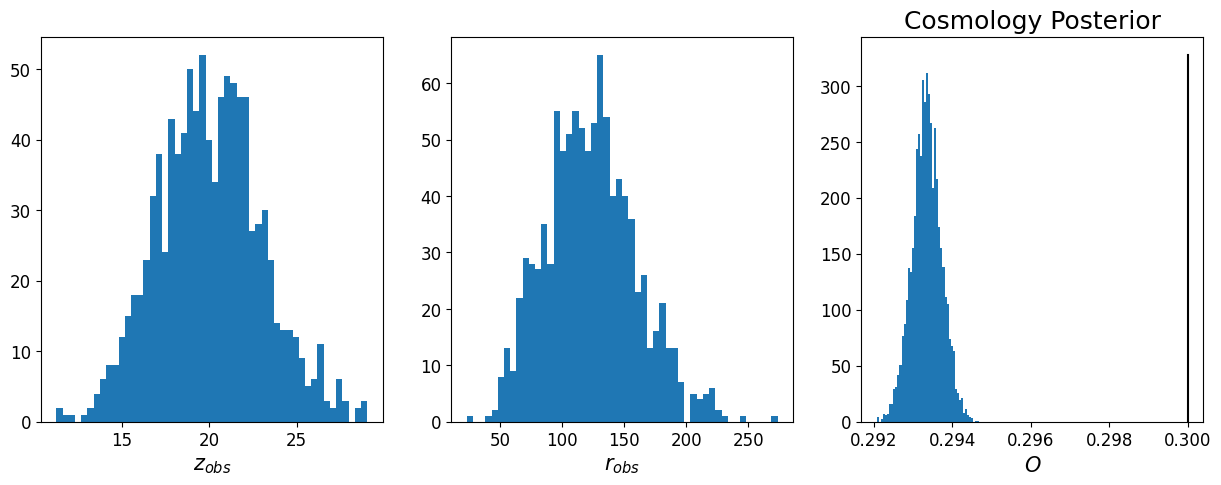

In [173]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
ax[0].hist(zL_test,bins=50)
ax[0].set_xlabel('$z_{obs}$',fontsize=15)
ax[1].hist(r_obs_test,bins=50)
ax[1].set_xlabel('$r_{obs}$',fontsize=15)
ax[2].hist(s_test.get_samples()['OM'].flatten(),bins=50)
ax[2].set_xlabel('$O$',fontsize=15)
ax[2].set_title('Cosmology Posterior',fontsize=18)
ylim2 = ax[2].get_ylim()
ax[2].plot([O_test,O_test],ylim2,c='k')
for i in range(3):
    ax[i].tick_params(labelsize=12)
pl.show()

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
ax[0].hist(zL_test,bins=50)
ax[0].set_xlabel('$z_{obs}$',fontsize=15)
ax[1].hist(r_obs_test,bins=50)
ax[1].set_xlabel('$r_{obs}$',fontsize=15)
ax[2].hist(s_test.get_samples()['OM'].flatten(),bins=50)
ax[2].set_xlabel('$O$',fontsize=15)
ax[2].set_title('Cosmology Posterior',fontsize=18)
ylim2 = ax[2].get_ylim()
ax[2].plot([O_test,O_test],ylim2,c='k')
for i in range(3):
    ax[i].tick_params(labelsize=12)
pl.show()

(array([   8.,   56.,  396., 1328., 2520., 2888., 1913.,  719.,  159.,
          13.]),
 array([-69.06533051, -53.85939026, -38.6534462 , -23.44750595,
         -8.2415638 ,   6.96437836,  22.17032051,  37.37626266,
         52.58220291,  67.78814697,  82.99408722]),
 <BarContainer object of 10 artists>)

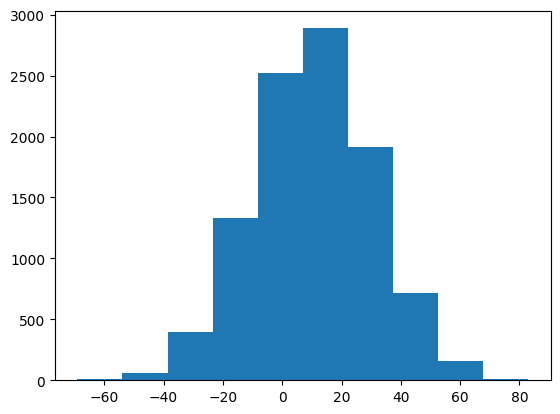

In [15]:
import matplotlib.pyplot as pl
pl.hist(zL_test)

#### MCMC Diagnostics
Useful link: https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

Second useful link: https://cran.r-project.org/web/packages/bayesplot/vignettes/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic

$\hat{R}$: The $\hat{R}$ statistic measures the ratio of the average variance of draws within each chain to the variance of the pooled draws across chains; if all chains are at equilibrium, these will be the same and $\hat{R}$ will be one. If the chains have not converged to a common distribution, the $\hat{R}$ statistic will be greater than one

Effective Sample Size: The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, neff, is usually smaller than the total sample size, N. It may be in some be cases > N: Useful Link https://statmodeling.stat.columbia.edu/2018/01/18/measuring-speed-stan-incorrectly-faster-thought-cases-due-antithetical-sampling/

In [ ]:
mcmc.get_samples(True)['mu'].shape
mcmc_db = pd.DataFrame()
for i in range(4):
    mcmc_db[f'mu_{i}'] = mcmc.get_samples(True)['mu'][i,:]
    mcmc_db[f'tau_{i}'] = mcmc.get_samples(True)['tau'][i,:]

retrieve_summary(mcmc_db)

In [ ]:
def plot_autocorrelation(chain,ax=None):
    if ax is None: fig,ax = pl.subplots(figsize=(5,3))
    ax.plot(autocorrelation(chain),c='k')
    ax.set_xlabel('Lag')
    ax.set_xlim(0,100)
    ax.set_ylim(-1,1)
    ax.plot([0,100],[0,0],'--',c='k')

#plot_autocorrelation(mcmc.get_samples(True)['mu'][0,:])
def retrieve_summary(JAX_chains,exclude=[]):
    chains_i = squash_walkers(JAX_chains,reshape=True,exclude=exclude)
    summary_db=pd.DataFrame(summary(chains_i))
    N_samples = squash_walkers(JAX_chains,exclude=exclude)
    return summary_db

a=retrieve_summary(JAX_chains,exclude=[2])
a

### Assorted Investigations 

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
a = np.random.random(size=int(1e+5))
b=2*np.random.random(size=int(1e+5))-1
c=1-(a+b)
hist_dict = {'density':True,'bins':np.linspace(-1,2,50)}
ax[0].hist(a[(c<1)&(c>0)],**hist_dict)
ax[1].hist(b[(c<1)&(c>0)],**hist_dict)
ax[2].hist(c[(c<1)&(c>0)],**hist_dict)
pl.show()

In [ ]:
#Pick some zL values:
zL_list_0 = np.round(np.arange(0.1,0.6,0.1),2)
#Choose range of zS to go with each one:
zS_list_0 = [np.arange(zL_i,2.1,0.1) for zL_i in zL_list_0]
#Calculate corresponding theoretical r value:
r_theory_list_0 = [r_SL(zL_list_0[i],zS_list_0[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_0))]
color_list_0 = pl.cm.viridis(np.linspace(0,1,len(zL_list_0)))

#Pick some zL values:
zS_list_1 = np.round(np.arange(0.2,2.2,0.2),2)
#Choose range of zL values to go with each one:
zL_list_1 = [np.arange(0,zS_i,0.001) for zS_i in zS_list_1]
#Calculate theoretical corresponding r value:
r_theory_list_1 = [r_SL(zL_list_1[i],zS_list_1[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_1))]
color_list_1 = pl.cm.viridis(np.linspace(0,1,len(zS_list_1)))

#Plot variation in r:
fig,ax = pl.subplots(1,2,figsize=(12,5))
for c_i in range(len(zL_list_0)):
    ax[0].plot(zS_list_0[c_i],r_theory_list_0[c_i],c=color_list_0[c_i])
for c_i in range(len(zS_list_1)):
    ax[1].plot(zL_list_1[c_i],r_theory_list_1[c_i],c=color_list_1[c_i])

ax[0].legend([f'$z_L$ = {zL_i}' for zL_i in  zL_list_0])
ax[1].legend([f'$z_S$ = {zS_i}' for zS_i in  zS_list_1])

ax[0].set_xlabel('$z_S$',fontsize=15)
ax[1].set_xlabel('$z_L$',fontsize=15)
for i in range(2):
    ax[i].set_ylabel('$r_{theory}$',fontsize=15)
    ax[i].set_ylim(0,1)

pl.show()

'''Takeaways: 
- Large variation in r if zL is unknown. If zL is uncertain, could explain many values of r within the uncertainty,
without resorting to constraining the cosmology.
- Large variation in r if zS is small and unknown, but smaller variation if zS is larger. If zS is uncertain but large, will get
smaller uncertainty in the theoretical value of r_theory, allowing more constraining power on the cosmology.
  '''

In [ ]:
#!python3 -m pip install arviz
import arviz as az
#az.style.use("arviz-plasmish")
az.style.use('arviz-doc')
#az.style.available

### MCMC Results

#### Load MCMC

In [9]:
Prefix = 'SL_orig_Gaussian_noise_'#'SL_orig_spectroscopic_db_'
Errors_perc = 0.05
N_samples = 8192
Perc_true = 100
contamination_str = 'True'
photometric_str = 'False'
cosmo_type_str = 'wCDM'
cosmo_db_str='wCDM'

range_dict = {'OM':(0,1),#(0.1,0.3),
              'Ode':(0.6,1),#(0.7,0.9),
              'Ok':(-1,1),
            'w':(-1.4,-0.6),'wa':(-3,1.5),
            'mu_zL_g_L':(0,1.5),'mu_zS_g_L':(0,3),
            'mu_zL_g_NL':(0,5),'mu_zS_g_NL':(0,5),
            'sigma_zL_g_L':(0,2),'sigma_zS_g_L':(0,2),
            'sigma_zL_g_NL':(0.1,5),'sigma_zS_g_NL':(0.1,5),
            'zL':(0,1.5),'zS':(0,3),'t':(0,2),'t_mu':(0,2)}
label_dict = {'OM':'$\Omega_m$','Ode':'$\Omega_\lambda$','Ok':'$\Omega_k$',
            'w':'$w_0$','wa':'$w_a$','H0':'H0',
            'mu_zL_g_L':'$\mu_{zL|L}$','mu_zL_g_NL':'$\mu_{zL|NL}$',
            'mu_zS_g_L':'$\mu_{zS|L}$','mu_zS_g_NL':'$\mu_{zS|NL}$',
            'sigma_zL_g_L':'$\sigma_{zL|L}$','sigma_zL_g_NL':'$\sigma_{zL|NL}$',
            'sigma_zS_g_L':'$\sigma_{zS|L}$','sigma_zS_g_NL':'$\sigma_{zS|NL}$',
            't':'Test Sampler','t_mu':'Test Sampler ($\mu$)'}

import glob;import pandas as pd
def locate_latest_chains(abs_or_perc,Errors,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,JAX=False,
                         cosmo_db_str='',return_db=False,list_of_file_indx = [],warmup=False,input_file=None):
    if cosmo_db_str=='':
        cosmo_db_str=cosmo_type_str
    file_search = f'./chains/{Prefix}{str(Errors).replace(".","p")}{abs_or_perc}_'+\
                                                 f'{N_samples}_samples_{Perc_true}_true_cosmo_{cosmo_db_str}.csv'+\
                                                 f'_ph_{photometric_str}_con_{contamination_str}'+\
                                                 f'_{cosmo_type_str}_'+\
                                                 'mcmc'*(JAX==False)+'JAX'*(JAX==True)+'_chains'
    print(file_search)
    mcmc_file_list = glob.glob(f'{file_search}*{"warmup"*warmup}.csv')
    if not warmup:
        mcmc_file_list = [elem for elem in mcmc_file_list if 'warmup' not in elem]
    print('File Found: ',mcmc_file_list)
    if input_file is not None:
        latest_chain_filename = input_file
        if not JAX: chains = np.load(latest_chain_filename) #[Walker,Step_Number,Parameter]
        if JAX: chains = pd.read_csv(latest_chain_filename)
        print(f'Loading mcmc chains from {latest_chain_filename}')
    elif len(list_of_file_indx)==0 and input_file is None:
        if not JAX: latest_chain_indx = np.argmax([float(elem.split('mcmc_chains_')[1].replace('.npy','')) \
                            for elem in mcmc_file_list])
        else: latest_chain_indx = np.argmax([float(elem.split('JAX_chains_')[1].replace('.csv','').replace('_warmup','')) \
                            for elem in mcmc_file_list])
        latest_chain_filename = mcmc_file_list[latest_chain_indx]
        if not JAX: chains = np.load(latest_chain_filename) #[Walker,Step_Number,Parameter]
        if JAX: chains = pd.read_csv(latest_chain_filename)
        print(f'Loading mcmc chains from {latest_chain_filename}')
    else:
        list_of_chains = [pd.read_csv(f'{file_search}_{elem}.csv') for elem in list_of_file_indx]
        for chain_i in list_of_chains:
            for chain_j in list_of_chains:
                assert chain_i.columns.tolist()==chain_j.columns.tolist() #Assert all columns are in each chain
        chains = pd.DataFrame()
        for column_i in list_of_chains[0].columns:
            column_i_str = column_i[:column_i.rfind('_')]
            for ii,chain_i in enumerate(list_of_chains):
                chains[f'{column_i_str}_{ii}'] = chain_i[column_i]
        latest_chain_filename = f'{file_search}_{list_of_file_indx[0]}.csv'
    if return_db:
        db_filename = latest_chain_filename.split('.csv')[0]+'.csv'
        db_filename = db_filename.replace('/chains','/databases').replace('SL_orig_','')
        db_i = pd.read_csv(db_filename)
        return chains,db_i
    else:
        return chains

# chain_dict = {}
# N_lens = 1000
# #for N_obs_i in np.linspace(1000,10000,10):
# for true_lens_frac in np.linspace(0.5,1,60):
#     N_obs_i = int(N_lens/true_lens_frac)
#     try:
#         chain_dict[int(np.round(100*N_lens/N_obs_i))] = locate_latest_chains(
#             'abs',Errors_perc,
#             contamination_str=contamination_str,
#             photometric_str=photometric_str,
#             cosmo_db_str=cosmo_db_str,
#             cosmo_type_str=cosmo_type_str,
#             N_samples = int(N_obs_i),
#             Perc_true = int(np.round(100*N_lens/N_obs_i)),
#             JAX=True,return_db=False,
#             warmup=False)
#         #print(retrieve_summary(chain_dict[int(np.round(100*N_lens/N_obs_i))],exclude=[]))
#     except Exception as ex:
#         print(f'Error for {N_obs_i} systems:{ex}')

chain_dict = {}
N_lens = 7500
Prefix = 'SL_orig_LensPop_Euclid_Gaussian_noise_'
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in []:#np.linspace(0.5,1,26):
    N_obs_i = int(N_lens/true_lens_frac)
    try:
        chain_dict[int(np.round(100*N_lens/N_obs_i))] = locate_latest_chains(
            'abs',Errors_perc,
            contamination_str=contamination_str,
            photometric_str=photometric_str,
            cosmo_db_str=cosmo_db_str,
            cosmo_type_str=cosmo_type_str,
            N_samples = int(N_obs_i),
            Perc_true = int(np.round(100*N_lens/N_obs_i)),
            JAX=True,return_db=False,
            warmup=False)
        #print(retrieve_summary(chain_dict[int(np.round(100*N_lens/N_obs_i))],exclude=[]))
    except Exception as ex:
        print(f'Error for {N_obs_i} systems:{ex}')

# chains = locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,cosmo_db_str=cosmo_db_str)
# JAX_chains,db_in = locate_latest_chains('abs',Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,
#                                         cosmo_type_str,JAX=True,cosmo_db_str=cosmo_db_str,return_db=True,
#                                         list_of_file_indx= [],
#         input_file = './chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_9375_samples_80_true_cosmo_wCDM.csv_ph_False_con_False_wCDM_JAX_chains_0.csv')



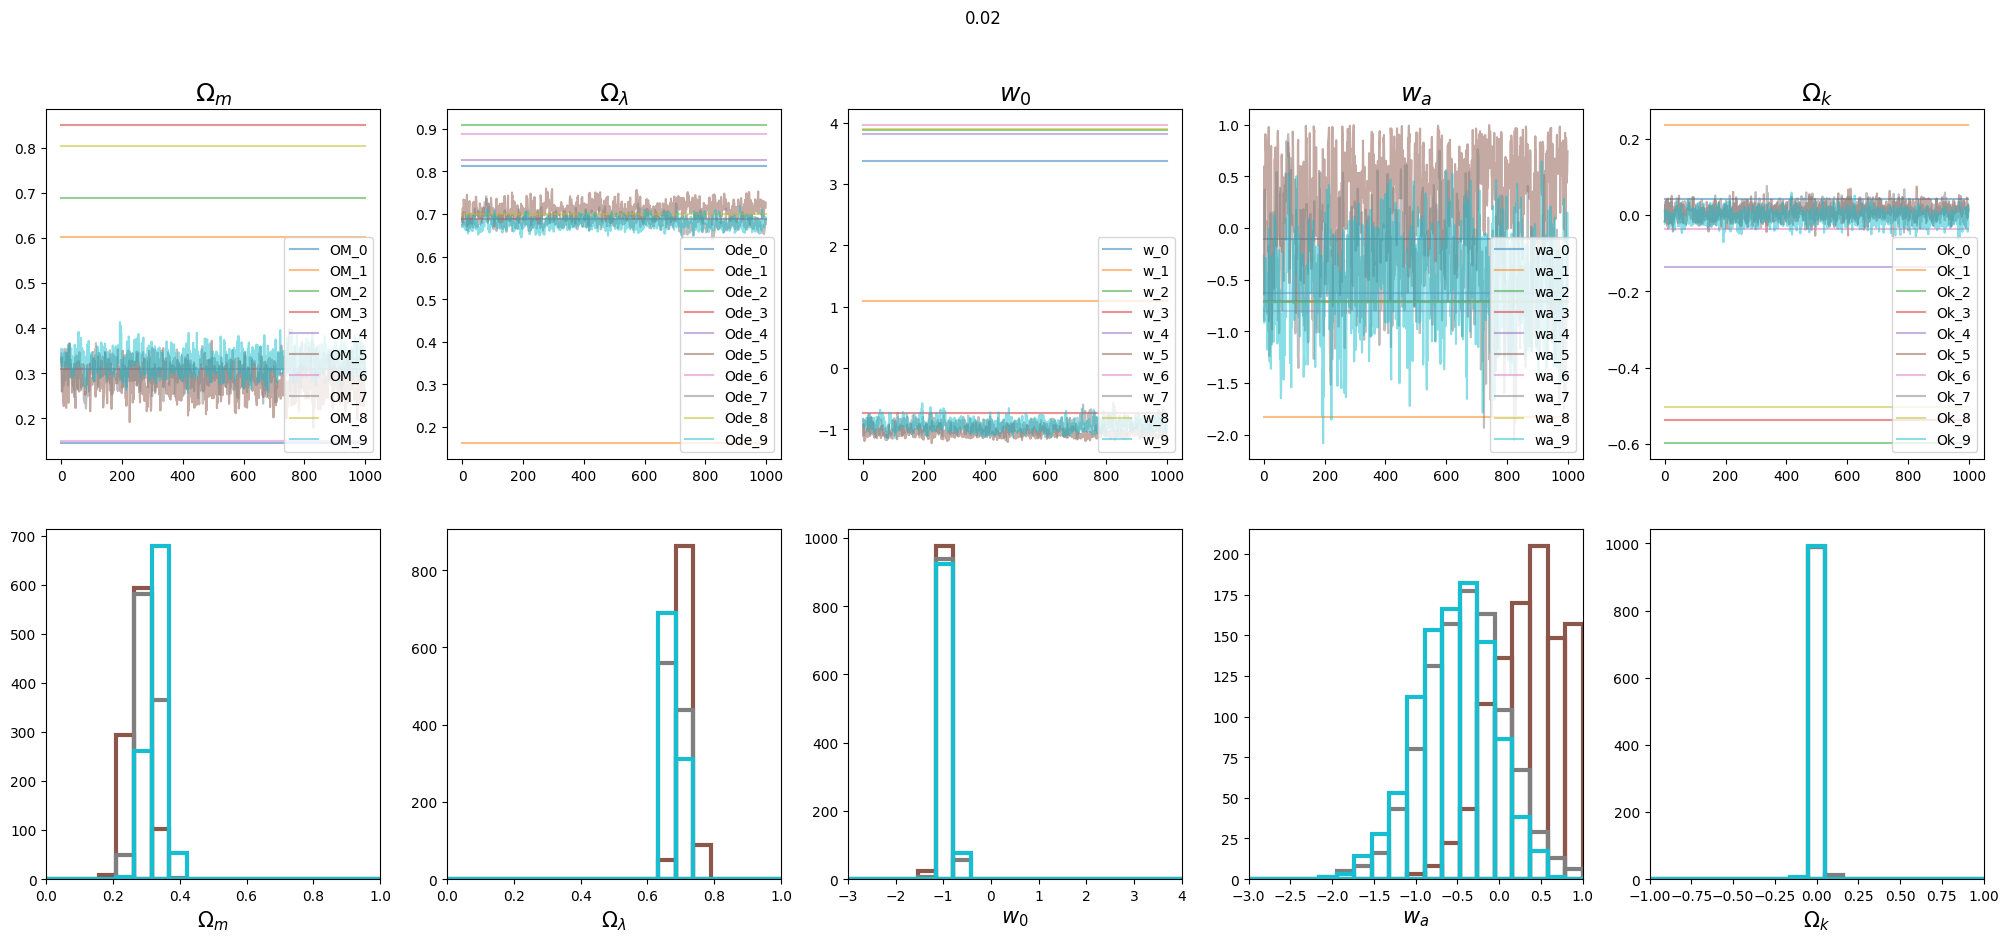

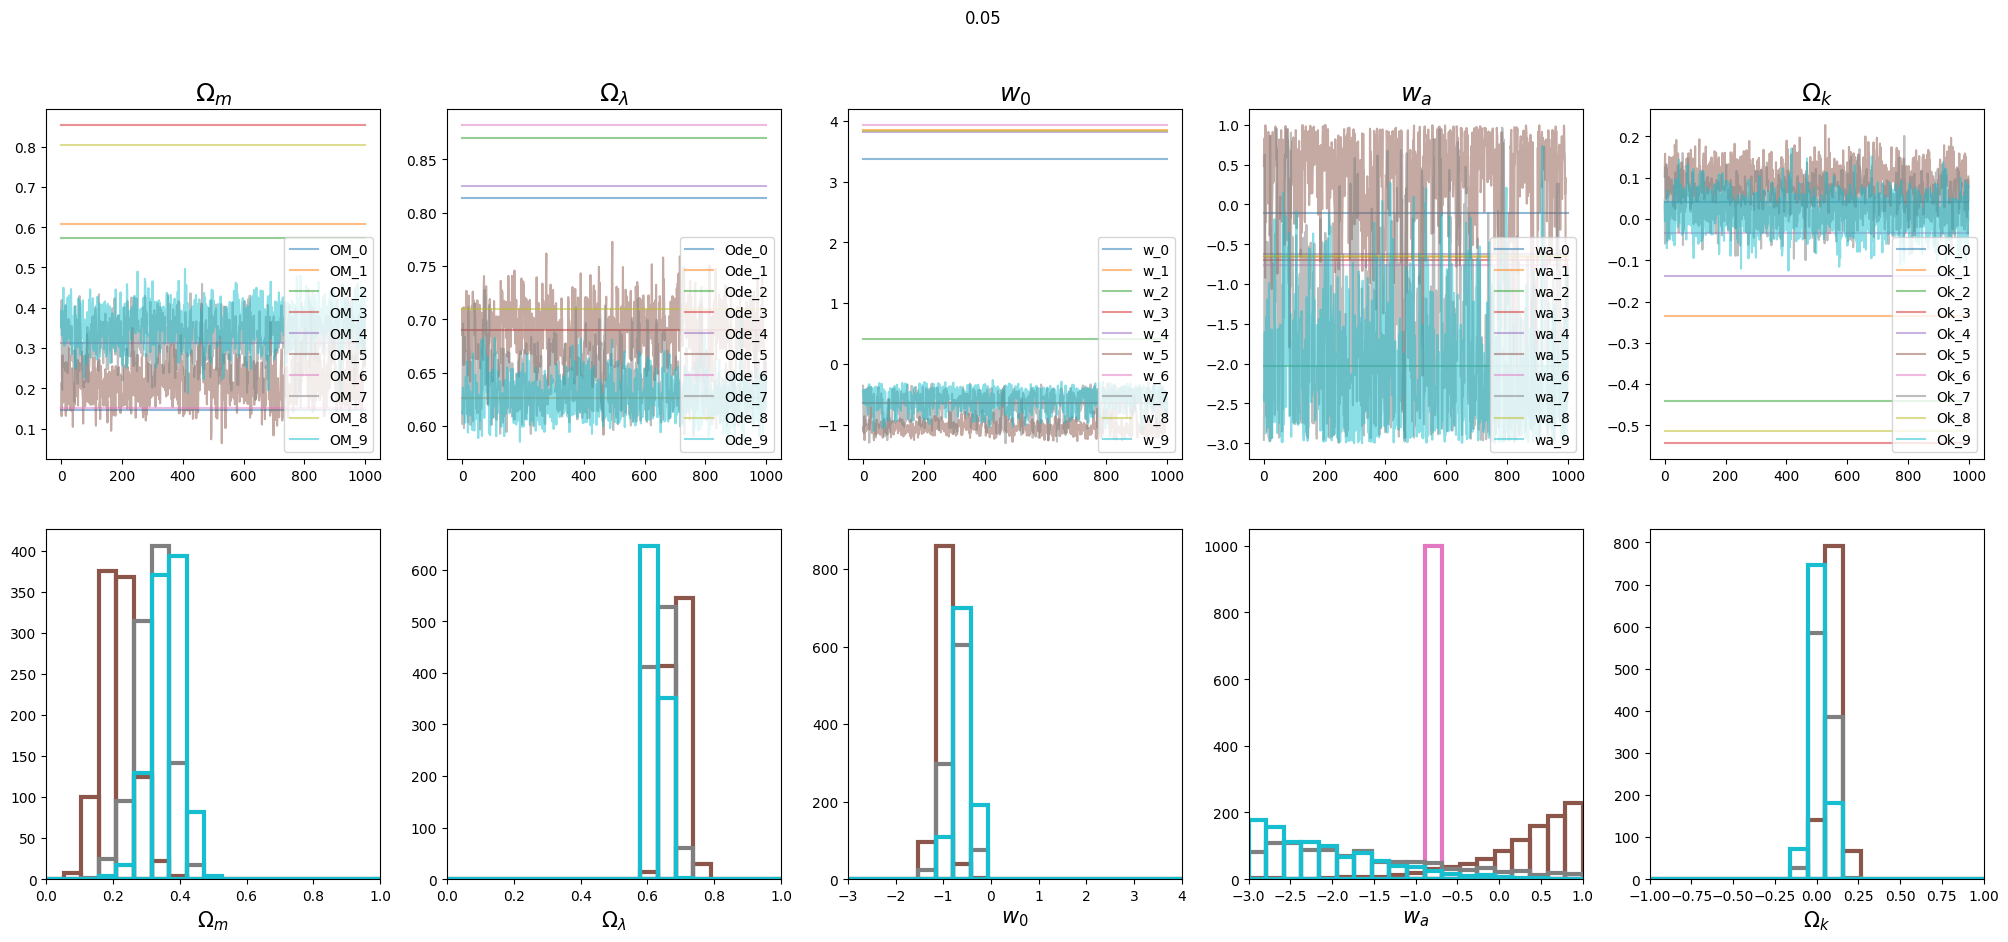

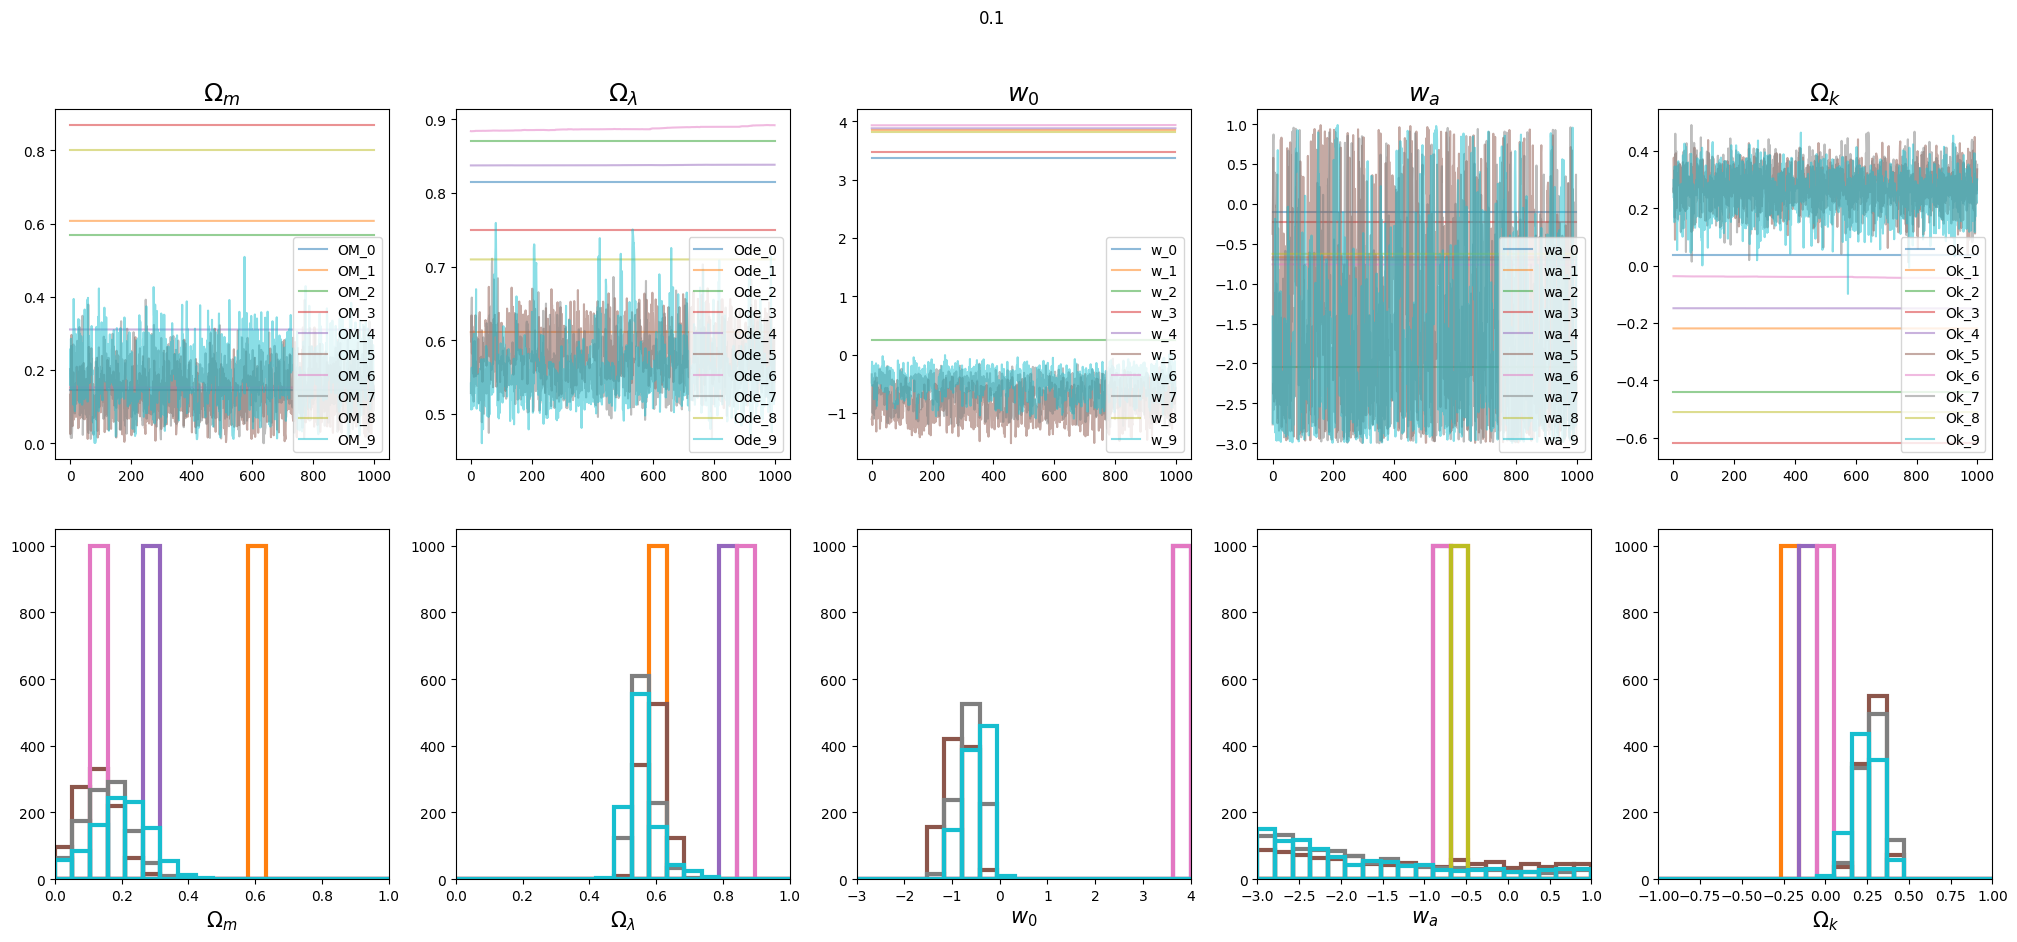

In [59]:
# chain_dict = {
#     7500:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_7500.csv_ph_True_con_False_wCDM_JAX_chains_0.csv'),
#     11250:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_11250.csv_ph_True_con_False_wCDM_JAX_chains_0.csv'),
#     15000:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_15000.csv_ph_True_con_False_wCDM_JAX_chains_0.csv'),
#     22500:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_22500.csv_ph_True_con_False_wCDM_JAX_chains_0.csv')}    

# for k_i in [7500,11250,15000,22500]:
#     plot_JAX_chains(chain_dict[k_i],plot_hist=True,title=k_i)

chain_dict = {
    0.02: pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1.csv'),
    0.05: pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1.csv'),
    0.1:  pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1.csv')}

for k_i in [0.02,0.05,0.1]:
    plot_JAX_chains(chain_dict[k_i],plot_hist=True,title=k_i,ignore_nonconverged=True)

In [15]:
zBEAMS_warmup_dict={}
for error_i in [0.02,0.05,0.1]:
    zBEAMS_warmup_dict[error_i] = locate_latest_chains(abs_or_perc='abs',
                     Errors=error_i,
                     N_samples=7500,
                     Perc_true=100,
                     contamination_str='False',
                     photometric_str='True',
                     cosmo_type_str='wCDM',
                     cosmo_db_str='wCDM',
                     JAX=True,warmup=True)

./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains
File Found:  ['./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_0_warmup.csv']
Loading mcmc chains from ./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_0_warmup.csv
./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains
File Found:  ['./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_0_warmup.csv']
Loading mcmc chains from ./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_0_warmup.csv
./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False

In [ ]:
FROM GROUP MEETING:
SIMON:
Check the likelihood is the same, before doing any MCMC, 
if it is the same, they should give the same result!
Perhaps can do specifically hamiltonian monte carlo if 
using jax - as then explicitly using the gradient - otherwise
am I just using numpyro + jax.jit? 

In [ ]:
c_list = ['zL_obs', 'zS_obs', 'sigma_zL_obs', 'sigma_zS_obs','r_obs_contam', 'sigma_r_obs']
fig,ax = pl.subplots(len(c_list),len(c_list),figsize=(10,10))
corner.corner(db_in[c_list],
              quantiles=[0.16,0.50,0.84],fig=fig)
for p_ii in range(len(c_list)):
    if p_ii in [2,3,5]: dp = 3
    else: dp=2
    ax[p_ii,p_ii].text(1,1,percentile_str(np.array(db_in[c_list])[:,p_ii],dp=dp),
                        horizontalalignment='right',
                        verticalalignment='top',
                        color='darkred',
                        transform=ax[p_ii,p_ii].transAxes,
                        fontsize=10)
#pl.tight_layout()
pl.show()

In [ ]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].scatter(db_in['sigma_zL_obs'],db_in['sigma_r_obs'],c='blue',s=1)
cov_db_in_zL = np.cov(np.array([db_in['sigma_zL_obs'],db_in['sigma_r_obs']]))
cov_db_in_zS = np.cov(np.array([db_in['sigma_zS_obs'],db_in['sigma_r_obs']]))

X_plot = np.linspace(0,0.2,100);Y_plot = np.linspace(0,0.2,100)
X_plot_3D,Y_plot_3D = np.meshgrid(X_plot,Y_plot)
ZL_plot = MVN(mean=np.mean([db_in['sigma_zL_obs'],db_in['sigma_r_obs']],axis=1),
             cov=cov_db_in_zL).pdf(np.array([X_plot_3D.flatten(),Y_plot_3D.flatten()]).T).reshape(100,-1)
ax[0].contour(X_plot_3D,Y_plot_3D,ZL_plot)
ZS_plot = MVN(mean=np.mean([db_in['sigma_zS_obs'],db_in['sigma_r_obs']],axis=1),
             cov=cov_db_in_zS).pdf(np.array([X_plot_3D.flatten(),Y_plot_3D.flatten()]).T).reshape(100,-1)
ax[0].contour(X_plot_3D,Y_plot_3D,ZL_plot)
ax[1].contour(X_plot_3D,Y_plot_3D,ZS_plot)
ax[1].scatter(db_in['sigma_zS_obs'],db_in['sigma_r_obs'],c='red',s=1)
for i in range(2): ax[i].set_ylabel('$\sigma_{r_{obs}}$')
ax[0].set_xlabel('$\sigma_{zL_{obs}}$')
ax[1].set_xlabel('$\sigma_{zS_{obs}}$')
ax[0].set_xlim([0,0.1]);ax[0].set_ylim([0,0.1])
ax[1].set_xlim([0,0.2]);ax[1].set_ylim([0,0.2])
pl.show()

#### Plot Individual Chains

In [58]:
def plot_JAX_chains(JAX_chains,fig=None,ax=None,zero=0,title=None,plot_hist=False,ignore_nonconverged=False):
    if fig is None: fig,ax = pl.subplots(1+plot_hist,5,figsize=(25,5*(1+plot_hist)))
    column_list = JAX_chains.columns
    color_list = pl.rcParams['axes.prop_cycle'].by_key()['color'] #Default colour list.
    #rfind finds the index of the last occurrence of the character in a string: 
    column_set = list(set([elem[:elem.rfind('_')] for elem in column_list]))
    column_dict = {"OM":0,"Ode":1,'w':2,'wa':3,'Ok':4}#,'mu_zL_g_L':4}
    range_dict = {'OM':(0,1),'Ode':(0,1),'wa':(-3,1),'w':(-3,4),'Ok':(-1,1)}
    for p_i,c_i in enumerate(JAX_chains.keys()):
        c_i_set = c_i[:c_i.rfind('_')]
        try: column_dict[c_i_set]
        except:continue
        try:
            if plot_hist: 
                ax_0 = ax[0,column_dict[c_i_set]]
            else: ax_0 = ax[column_dict[c_i_set]]
            ax_0.plot(zero+np.arange(len(JAX_chains[c_i])),np.array(JAX_chains[c_i]),
                                         alpha=0.5,label=c_i,color=color_list[p_i%len(color_list)])
            ax_0.set_title(label_dict[c_i_set],fontsize=18,fontweight='bold')
            ax_0.legend(loc='lower right')
        except Exception as ex:
            pass 
    #Have to do second loop to plot the histograms with equal bins:
    for p_i,c_i in enumerate(JAX_chains.keys()):
        #print(c_i,c_i_set)
        c_i_set = c_i[:c_i.rfind('_')]
        try: column_dict[c_i_set]
        except: continue
        if plot_hist: 
            ax_1 = ax[1,column_dict[c_i_set]]
            #limits_i = ax[0,column_dict[c_i_set]].get_ylim()
            bins_i = np.linspace(range_dict[c_i_set][0],range_dict[c_i_set][1],20)
            color_i = color_list[p_i%len(color_list)]
            if ignore_nonconverged:
                if len(set(np.array(JAX_chains[c_i])))<10: continue
            ax_1.hist(np.array(JAX_chains[c_i]),fill=False,edgecolor=color_i,bins = bins_i,linewidth=3)
            ax_1.set_xlabel(label_dict[c_i_set],fontsize=15)
            ax_1.set_xlim(range_dict[c_i_set])
            #ax[column_dict[c_i_set]].set_title(c_i)        
    #pl.suptitle(f'Key: {k_i}')
    if title is not None: pl.suptitle(title)
    if fig is None: pl.show()

pl.close()
for k_i in []:#chain_dict.keys():
    JAX_chains = chain_dict[k_i]
    plot_JAX_chains(JAX_chains,title=k_i)
    pl.show()
#plot_JAX_chains(JAX_chains,plot_hist=True)

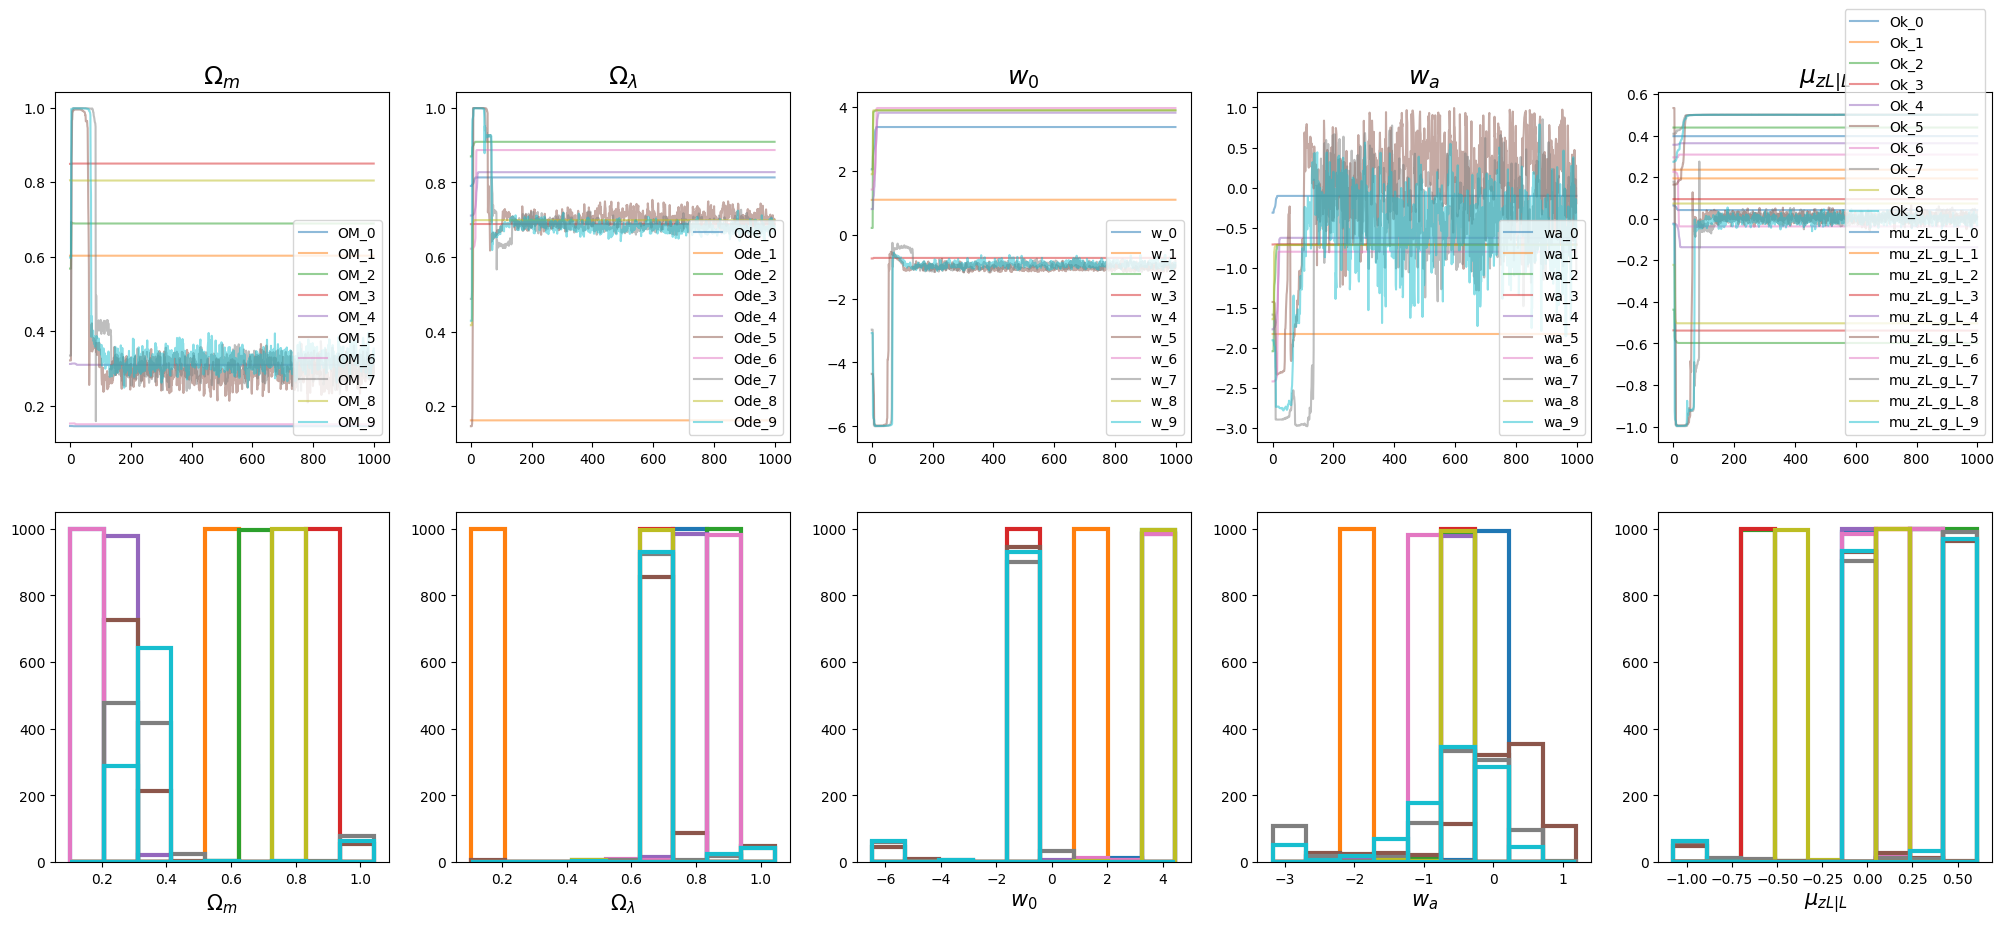

In [29]:
plot_JAX_chains(zBEAMS_warmup_dict[0.02],plot_hist=True)

In [ ]:
def retrieve_JAX_redshifts(JAX_chains,merge_chains=True,exclude = []):
    column_list = JAX_chains.columns
    zL_column_list = [elem for elem in column_list if elem[0:2]=='zL']
    zS_column_list = [elem for elem in column_list if elem[0:2]=='zS']
    zL_chain_dict = {};zS_chain_dict = {}
    for c_i in range(len(zL_column_list)):
        N_chain = zL_column_list[c_i].split('_')[2]
        try:
            zL_chain_dict[N_chain].append(zL_column_list[c_i])
            zS_chain_dict[N_chain].append(zS_column_list[c_i])
        except:
            zL_chain_dict[N_chain] = [zL_column_list[c_i]]
            zS_chain_dict[N_chain] = [zS_column_list[c_i]]
    zL_inferred = [];zS_inferred = []
    for k_i in zL_chain_dict:
        if int(k_i) in exclude: print('Excluding');continue
        zL_inferred.append(JAX_chains[zL_chain_dict[k_i]].mean(axis=0).tolist())
        zS_inferred.append(JAX_chains[zS_chain_dict[k_i]].mean(axis=0).tolist())
    if merge_chains: return np.array(zL_inferred).mean(axis=0),np.array(zS_inferred).mean(axis=0)
    else: return np.array(zL_inferred),np.array(zS_inferred)


def check_inferred_redshifts(db_in,JAX_chains,N_redshifts=20,N_chains=4,exclude = []):
    '''Plots the inferred redshifts from the JAX MCMC against the observed redshifts from the input catalogue'''
    zL_inferred,zS_inferred = retrieve_JAX_redshifts(JAX_chains,merge_chains=True,exclude=exclude)
    fig = pl.figure(figsize=(8,5))
    pl.scatter(db_in['zL_obs'][0:len(zL_inferred)],zL_inferred,c='blue',label='Lens',alpha=0.5)
    pl.scatter(db_in['zS_obs'][0:len(zS_inferred)],zS_inferred,c='red',label='Source',alpha=0.5)
    pl.plot([0,2],[0,2],c='k')
    pl.legend()
    pl.xlabel('True Redshift')
    pl.ylabel('Inferred Redshift')
    pl.show()

check_inferred_redshifts(db_in,JAX_chains,exclude = [])

In [ ]:
z_posterior_sample = MVN(
    mean =np.array([post['mu_zL_g_L'].mean(),post['mu_zS_g_L'].mean()]),
    cov = np.array([post['sigma_zL_g_L'].mean(),post['sigma_zS_g_L'].mean()])**2, #COVARIANCE not SIGMA hence **2.
    ).rvs(size=int(1e+4))

fig, ax = pl.subplots(1,3,figsize=(15,5))
#NOTE: No restriction here to be a truncated normal distribution so some of the apparently inferred values will be <0
ax[0].scatter(z_posterior_sample[:,0],z_posterior_sample[:,1],alpha=0.3,s=1,label='Inferred Population',c='blue')
ax[0].scatter(db_in['zL_obs'],db_in['zS_obs'],s=1,label='True Population',c='orange')
#
ax[0].errorbar(
        x = post['mu_zL_g_L'].mean(),
        y = post['mu_zS_g_L'].mean(),
        xerr = post['sigma_zL_g_L'].mean(),
        yerr = post['sigma_zS_g_L'].mean(), 
        fmt='.',label='_nolabel_',c='darkblue',zorder=5)
ax[0].errorbar(
        x=db_in['zL_obs'].mean(),
        y=db_in['zS_obs'].mean(),
        xerr=db_in['zL_obs'].std(),
        yerr = db_in['zS_obs'].std(),
        fmt='.',label='_nolabel_',c='darkorange')

#pl.xlim(left=-0.1);pl.ylim(bottom=-0.1)
ax[0].legend(loc='upper right')
ax[0].set_xlabel('$z_L$')
ax[0].set_ylabel('$z_S$')

hist_dict_1 = {'alpha':0.5,'density':True,'bins':np.linspace(-1,2,30)}
hist_dict_2 = {'alpha':0.5,'density':True,'bins':np.linspace(-0.5,2.5,30)}
ax[1].hist(db_in['zL_obs'],**hist_dict_1,color='orange',label='True Population')
ax[1].hist(z_posterior_sample[:,0],**hist_dict_1,color='blue',label='Inferred Population')
ax[2].hist(db_in['zS_obs'],**hist_dict_2,color='orange',label='True Population')
ax[2].hist(z_posterior_sample[:,1],**hist_dict_2,color='blue',label='Inferred Population')
ax[1].legend();ax[2].legend()
pl.show()

#### Attempts at Covariance

Think don't bother with this for the moment. Think the paltas code will hopefully give me covariances which will automatically be suitable (they will have to be viable covariance matrices!) which I can use straight off, without botching up simulating covariances here then not even using them. 

In [ ]:
#Code from here: https://janakiev.com/blog/covariance-matrix/
C=np.array([[1,0.5],[0.5,3]])
eVe, eVa = np.linalg.eig(C)
print('Major axis',np.argmax(eve)
X_inf,Y_inf = MVN(mean=[0,0],cov=C).rvs(10000).T
pl.scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
for e, v in zip(eVe, eVa.T):
    print('V1',[0, v[0]])
    print('V2',[0, v[1]])
    pl.plot([0, 3*np.sqrt(e)*v[0]],
            [0, 3*np.sqrt(e)*v[1]], 'k-', lw=2)
pl.title('Transformed Data')
pl.axis('equal')

In [ ]:
#Code from here: https://janakiev.com/blog/covariance-matrix/

def angle_guess(x,y):
    if x<0:
        if y<0: 
            return np.arctan(y/x)-np.pi
        if y>0:
            return np.arctan(y/x)+np.pi
    else: return np.arctan(y/x)


def plot_eigenvectors(cov,ax=None):
    if ax is None: fig,ax = pl.subplots(1,figsize=(8,5))
    eigen_value, eigen_vector = np.linalg.eig(cov)
    major_axis_indx = np.argmax(eigen_value)
    ax.plot([0, 3*np.sqrt(eigen_value[major_axis_indx])*eigen_vector[0][major_axis_indx]],
            [0, 3*np.sqrt(eigen_value[major_axis_indx])*eigen_vector[1][major_axis_indx]], 'k-', lw=2)
    pl.axis('equal')
    ax.set_title(f'Angle: '+str((180/np.pi)*angle_guess(eigen_vector[0][major_axis_indx],
                                          eigen_vector[1][major_axis_indx])))

def cov_diag(var_xx,var_yy,angle,unit='radians'): #Angle in radians
    assert unit in ['radians','deg']
    if unit=='deg': angle*=(2*np.pi/360)
    return 0.5*np.tan(2*angle)*(var_xx-var_yy)

fig,ax = pl.subplots(5,2,figsize=(10,20))
for p_i,angle_i in enumerate(np.linspace(0,90,10)):
    y=p_i%2;x=p_i//2
    cov_00=1;cov_11=1.5
    cov_diag_ii = cov_diag(cov_00,cov_11,angle_i,unit='deg')
    cov_ii = np.array([[cov_00,cov_diag_ii],
                       [cov_diag_ii,cov_11]])
    #ax[x,y].set_title(angle_i)
    try:
        X_inf,Y_inf = MVN(mean=[0,0],cov=cov_ii).rvs(10000).T
        ax[x,y].scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
        plot_eigenvectors(cov_ii,ax=ax[x,y])
    except Exception as ex:
        print(ex)
        pass
pl.show()

In [ ]:
2.6**2

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as pl

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def return_angle(cov):
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    print('Vectors:',vecs,'Theta',theta)
    x,y = vecs[:,0][::-1]
    #theta=np.degrees(np.arctan(x/y))
    if x<0:
        if y<0: theta-=180
        if y>0: theta+=180
    if theta>180: theta-=360
    if theta<-180: theta+=360
    return theta

def cov_diag(var_xx,var_yy,angle,unit='radians'): #Angle in radians
    assert unit in ['radians','deg']
    if unit=='deg': angle*=(2*np.pi/360)
    return 0.5*np.tan(2*angle)*(var_xx-var_yy)

fig,ax = pl.subplots(4,2,figsize=(5,12))
C_list = [np.array([[4,0],[0,0.1]]),
          np.array([[0.1,0],[0,4]]),
          np.array([[4,0.9],[0.9,1]]),
          np.array([[1,0.9],[0.9,4]]),
          np.array([[2,-0.9],[-0.9,1]]),
          np.array([[1,-0.9],[-0.9,2]]),
          np.array([[4,-0.9],[-0.9,1]]),
          np.array([[1,-0.9],[-0.9,4]])]

for p_i in range(0):#len(C_list)):
    y=p_i%2;x=p_i//2
    X,Y = MVN(np.array([0,0]),cov=C_list[p_i]).rvs(10000).T
    angle_i = return_angle(C_list[p_i])
    cov_diag_i = cov_diag(C_list[p_i][0,0],C_list[p_i][1,1],angle_i,unit='deg')
    X_inf,Y_inf = MVN(np.array([0,0]),
                      np.array([[C_list[p_i][0,0],cov_diag_i],
                               [cov_diag_i,C_list[p_i][1,1]]])).rvs(10000).T
    ax[x,y].scatter(X,Y,s=0.1)
    ax[x,y].scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
    ax[x,y].set_title(str(C_list[p_i].tolist())+',\n'+str(return_angle(C_list[p_i])))
    ax[x,y].axis('square')
    ax[x,y].set_xlim([-4,4])
    ax[x,y].set_ylim([-4,4])

pl.tight_layout()
pl.show()

In [5]:
import numpy as np
np.cov(np.array([[1,2,3],[10,25,50]]))

array([[  1.        ,  20.        ],
       [ 20.        , 408.33333333]])

In [ ]:
C_0 = 4;C_1 = 1
Angle_list = np.linspace(0,180,20)
fig,ax = pl.subplots(len(Angle_list)//2,2,figsize=(5,len(Angle_list)))
for p_i,angle_i in enumerate(Angle_list):
    y=p_i%2;x=p_i//2
    try:
        cov_diag_i = cov_diag(C_0,C_1,angle_i,unit='deg')
        cov_i = np.array([[C_0,cov_diag_i],
                          [cov_diag_i,C_1]])
        r_angle_i = return_angle(cov_i)
        cov_ii = np.array([[C_0,-cov_diag_i],
                          [-cov_diag_i,C_1]])
        r_angle_ii = return_angle(cov_ii)
        cov_iii = np.array([[C_0,cov_diag_i],
                          [-cov_diag_i,C_1]])
        cov_iiii = np.array([[C_0,-cov_diag_i],
                          [cov_diag_i,C_1]])
        r_angle_iii = return_angle(cov_iii)
        r_angle_iiii = return_angle(cov_iiii)
        r_angle_dict = {1:r_angle_i,2:r_angle_ii,3:r_angle_iii,4:r_angle_iiii}
        cov_dict = {1:cov_i,2:cov_ii,3:cov_iii,4:cov_iiii}
        cov_found=False
        for c_i in r_angle_dict.keys():
            if r_angle_dict[c_i]<0: r_angle_dict[c_i]+=180
            if r_angle_dict[c_i]>180: r_angle_dict[c_i]-=180
            if np.round(r_angle_dict[c_i],3)==np.round(angle_i,3):
                cov_retrieved_true = cov_dict[c_i]
                cov_found=True
        print(cov_found,angle_i,r_angle_dict)
        assert cov_found
        X_inf,Y_inf = MVN(np.array([0,0]),
                        cov_retrieved_true).rvs(10000).T
        ax[x,y].scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
    except Exception as ex:
        pass
    ax[x,y].set_title(np.round(angle_i,2))
    ax[x,y].axis('square')
    ax[x,y].set_xlim([-4,4])
    ax[x,y].set_ylim([-4,4])

pl.tight_layout()
pl.show()

In [ ]:
def plot_contour_point(mu_x,mu_y,sig_x,sig_y,min_x=0,max_x=1,min_y=0,max_y=1,cov_diag=0):
    X_plot = np.linspace(min_x,max_x,1000);Y_plot = np.linspace(min_y,max_y,1000)
    X_plot_3D,Y_plot_3D = np.meshgrid(X_plot,Y_plot)
    XY_plot_flat = np.array([X_plot_3D.flatten(),Y_plot_3D.flatten()]).T
    cov = np.array([[sig_x**2,cov_diag],
                    [cov_diag,sig_y**2]])
    print(cov)
    MVN_0 = MVN(mean=[mu_x,mu_y],
                cov=cov)
    ZL_plot = MVN_0.pdf(XY_plot_flat).reshape(1000,-1)
    Z_1sig = MVN_0.pdf(np.array([mu_x,mu_y+sig_y])) #1 sigma pdf value => Only go along 1 axis otherwise is >1sigma
    pl.contour(X_plot_3D,Y_plot_3D,ZL_plot,levels=np.array([Z_1sig]))
    pl.errorbar(mu_x,mu_y,xerr=sig_x, yerr=sig_y,c='k')
    #Doesn't return anything as want to keep each plot on figure.

In [ ]:
zL_r_angle = return_angle(np.cov([db_in['zL_obs'],db_in['r_obs_contam']]))

fig = pl.figure(figsize=(10,5))
rand_db_indx = np.random.choice(np.arange(len(db_in)),replace=False,size=10)
pl.errorbar(
    db_in['zL_obs'].loc[rand_db_indx],
    db_in['r_obs_contam'].loc[rand_db_indx],
    xerr=db_in['sigma_zL_obs'].loc[rand_db_indx],
    yerr=db_in['sigma_r_obs'].loc[rand_db_indx],
    fmt='.',markersize=1,linewidth=1,c='k')

for indx in tqdm(rand_db_indx):
    try:
        cov_diag_ii = cov_diag(
            db_in['sigma_zL_obs'][indx]**2,
            db_in['sigma_r_obs'][indx]**2,
            10,unit='deg')
        plot_contour_point(
                    db_in['zL_obs'][indx],
                    db_in['r_obs_contam'][indx],
                    db_in['sigma_zL_obs'][indx],
                    db_in['sigma_r_obs'][indx],
                    cov_diag=0)#cov_diag_ii)
    except Exception as ex: 
        print(ex)#pass
#X,Y = MVN(np.array([0,0]),cov=cov_db_00).rvs(len(db_in)).T
#X,Y = MVN(np.array([0,0]),cov=cov_db_00).rvs(len(db_in)).T
#ax[0].scatter(X,Y,s=1)
pl.xlabel('$z_{L,obs}$')
pl.ylabel('$r_{obs}$')
pl.axis('square')
pl.show()

#### Diagnostics

In [ ]:
def plot_inferred_redshift_pop(JAX_chains,db_in,exclude = []):
    fig,ax = pl.subplots(1,figsize=(10,5))
    hist_dict = {'bins':np.linspace(0,2,50),'fill':False,'density':True}
    JAX_squash = squash_walkers(JAX_chains,exclude=exclude)
    ax.hist(db_in['zL_obs'],**hist_dict,edgecolor='blue',zorder=2,label='$zL_{obs}$')
    ax.hist(db_in['zS_obs'],**hist_dict,edgecolor='red',label='$zS_{obs}$')
    #Inferred zL and zS population
    ax.errorbar(JAX_squash['mu_zL_g_L'].mean(),1.5,xerr=JAX_squash['sigma_zL_g_L'].mean(),fmt='.',label='Inferred $\mu_{zL}$')
    ax.errorbar(JAX_squash['mu_zS_g_L'].mean(),1.4,xerr=JAX_squash['sigma_zS_g_L'].mean(),fmt='.',label='Inferred $\mu_{zS}$')
    #True zL and zS population 
    ax.errorbar(db_in['zL_obs'].mean(),2,xerr=db_in['zL_obs'].std(),fmt='.',label='True zL')
    ax.errorbar(db_in['zS_obs'].mean(),1.9,xerr=db_in['zS_obs'].std(),fmt='.',label='True zS')
    pl.legend()
    pl.xlabel('Redshift')
    pl.show()

plot_inferred_redshift_pop(JAX_chains,db_in,exclude = [])

In [ ]:
fig,ax = pl.subplots(1,5,figsize=(20,5))
for p_i in range(5):
    for i in range(len(chains)):
        ax[p_i].plot(chains[i,:,p_i],c='k',alpha=0.05)
    if p_i<5: ax[p_i].set_xlabel(['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$'][p_i],fontsize=15)
pl.show()

In [ ]:
#!python3 -m pip install seaborn
from seaborn import kdeplot
bin_dict = {elem: np.linspace(range_dict[elem][0],range_dict[elem][1],20) for elem in range_dict.keys()}

def plot_1D_hist(JAX_sampler,fig=None,ax=None,N_keys=None,iter=np.nan,label='_nolegend_',
                 two_rows=False,exclude=[]):
    cl = pl.cm.viridis(np.linspace(0,1,N_keys+1))[iter]
    k_list = ['OM','Ode','w','wa','Ok']
    plot_N = len(k_list)
    for k_i in k_list: 
        if k_i not in squash_walkers(JAX_sampler,exclude=exclude,verbose=False).columns: plot_N-=1;k_list.remove(k_i)
    if fig is None: fig,ax = pl.subplots(1+two_rows,plot_N,figsize=(5*plot_N,5*(1+two_rows)))
    hist_dict = {'fill':False,'density':True}
    for p_i,k_i in enumerate(k_list):
        if two_rows: ax_i = ax[0,p_i]
        else: ax_i = ax[p_i]
        kdeplot(data=squash_walkers(JAX_sampler,exclude=exclude,verbose=False)[k_i], ax=ax_i,color=cl,label=label)
        if iter==N_keys-1: 
            ax_i.set_xlabel(label_dict[k_i],fontsize=18)
            ax_i.set_ylabel('Probability Density',fontsize=18)
            ax_i.tick_params(labelsize=15)
            ylim = ax_i.get_ylim()
            ax_i.set_ylim(ylim)
            ax_i.set_xlim(range_dict[k_i])
            ax_i.plot([{'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid,'Ok':1-(Om_fid+Ode_fid)}[k_i]]*2,ylim,c='k')
            #if p_i ==2: ax_i.set_xlim(-2.5,0)

    return fig,ax

def plot_uncertainty(JAX_sampler,fig,ax,N_keys=None,iter=np.nan,perc_true=np.nan,
                     two_rows=False,exclude=[]):
    cl = pl.cm.viridis(np.linspace(0,1,N_keys+1))[iter]
    k_list = ['OM','Ode','w','wa','Ok']
    plot_N = len(k_list)
    for k_i in k_list: 
        if k_i not in squash_walkers(JAX_sampler,exclude=exclude,verbose=False).columns: plot_N-=1;k_list.remove(k_i)
    if fig is None: fig,ax = pl.subplots(1,plot_N,figsize=(5*plot_N,5))
    for p_i,k_i in enumerate(k_list):
        if two_rows: ax_i = ax[1,p_i]
        else: ax_i = ax[p_i]
        chains_i = squash_walkers(JAX_sampler,exclude=exclude,verbose=False)[k_i]
        perc_50 = np.median(chains_i)
        perc_84 = np.percentile(chains_i,84)
        perc_16 = np.percentile(chains_i,16)
        ax_i.errorbar(perc_true,perc_50,color=cl,yerr=np.array([[perc_50-perc_16,perc_84-perc_50]]).T,fmt='.')
        if iter==N_keys-1: 
            #ax_i.set_xscale('log')
            ax_i.set_xlabel('% True Lenses',fontsize=18)
            ax_i.set_ylabel(f'1D Posterior, {label_dict[k_i]}',fontsize=18)
            ax_i.tick_params(labelsize=15)
            xlim = ax_i.get_xlim();ax_i.set_xlim(xlim)
            ax_i.plot(xlim,[{'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid,'Ok':1-(Om_fid+Ode_fid)}[k_i]]*2,c='k')
        ax_i.set_ylim(range_dict[k_i])
    return fig,ax

fig,ax = None,None
N_keys = len(chain_dict.keys())
exclusion_zone = {}
for ii,k_ii in tqdm(enumerate(chain_dict.keys())):
    #if ii!=N_keys-1: continue #=> Plots only the last key.
    '''
    Excluding chains for which <90% of the values are unique, indicating the chains haven't converged:
    Update: This made no discernable difference!
    '''
    exclude_i = list(set([int(elem.split('_')[-1]) for elem in chain_dict[k_ii].columns if \
                         len(set(chain_dict[k_ii][elem]))<0.9*len(chain_dict[k_ii])]))
#     for w_ii in range(10):
#         if np.median(chain_dict[k_ii][f'wa_{w_ii}'])<=-2: exclude_i.append(w_ii)
    posterior_dict = {'N_keys':N_keys,'iter':ii,'two_rows':True,'exclude':exclude_i}
    print(f'Excluding {exclude_i}')
    exclusion_zone[k_ii]=exclude_i
    fig,ax = plot_1D_hist(chain_dict[k_ii],label=f'{k_ii}% true.',**posterior_dict,fig=fig,ax=ax)
    fig,ax = plot_uncertainty(chain_dict[k_ii],perc_true=k_ii,**posterior_dict,fig=fig,ax=ax)

pl.suptitle('Posteriors on Cosmology',fontsize=21)
pl.tight_layout()
pl.show()

In [ ]:
fig,ax=None,None
N_keys = len(chain_dict.keys())
for ii,k_ii in tqdm(enumerate(chain_dict.keys())):
    fig,ax=plot_uncertainty(chain_dict[k_ii],perc_true=k_ii,fig=fig,ax=ax,
                              two_rows=False,N_keys=N_keys,iter=ii)
pl.tight_layout()
N_files = len(glob.glob('./zBEAMS_plots/Posterior_Uncertainties_with_contamination*.png'))
for fmt_i in ['.png','.pdf']:
    pl.savefig(f'./zBEAMS_plots/Posterior_Uncertainties_with_contamination_{N_files}{fmt_i}',
               transparent=True)
pl.show()

In [ ]:
Perc_list = np.arange(50,102,2).astype('int')
N_samples_list = 2**np.arange(1,11)
#fig,ax = pl.subplots(1,len(Perc_list),figsize=(5*len(Perc_list),5))
fig,ax = pl.subplots(1,4,figsize=(20,5))
mu_dict = {}
si_dict = {}
#for p_i in range(len(Perc_list)):
for p_i in range(len(N_samples_list)):
    chains_i = locate_latest_chains(Errors_perc=1,
                                    N_samples=N_samples_list[p_i],
                                    Perc_true=100,
                                    contamination_str='False',
                                    photometric_str='False',
                                    cosmo_type_str='wCDM')
    N_steps_i = len(chains_i[0,:,0])
    burnin_i = int(0.5*N_steps_i)
    print(f'Found {N_steps_i} steps, using burnin of {burnin_i}')
    try: 
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']): 
            mu_dict[cosmo_prop].append(np.mean(chains_i[:,burnin_i:,c_i]))
            si_dict[cosmo_prop].append(np.std(chains_i[:,burnin_i:,c_i]))
    except:
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
            mu_dict[cosmo_prop] = [np.mean(chains_i[:,burnin_i:,c_i])]
            si_dict[cosmo_prop] = [np.std(chains_i[:,burnin_i:,c_i])]

for ii,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
#    ax[ii].errorbar(Perc_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
    ax[ii].errorbar(N_samples_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
#    ax[ii].set_xlabel('% true lenses',fontsize=15)
    ax[ii].set_xlabel('Sample Size',fontsize=15)
    ax[ii].set_xscale('log')
    ax[ii].set_ylabel('$\mu\pm\sigma$',fontsize=15)
    ax[ii].set_title({'Om':'$\Omega_m$','Ode':'$\Omega_\Lambda$','H0':'$H_0$','w':'$w$','wa':'$w_a$'}[cosmo_prop],fontsize=18)
    ax[ii].tick_params(labelsize=10)
#    ax[ii].plot([min(Perc_list),max(Perc_list)],[[Om_fid,Ode_fid,H0_fid,w_fid][ii]]*2,c='k')
    ax[ii].plot([min(N_samples_list),max(N_samples_list)],[[Om_fid,Ode_fid,H0_fid,w_fid,wa_fid][ii]]*2,c='k')

#pl.suptitle('Precision with contaminated sample',fontsize=18)
pl.suptitle('Precision with varying sample size',fontsize=18)
pl.tight_layout()
pl.show()

In [ ]:
chain_dict[100]

#### MCMC Corner Plots

In [ ]:
def del_chains_in_mcmc(mcmc_dict,exclude):
    print(f'Excluding {exclude} from emcee plots')
    for k_ii in mcmc_dict.keys():
        L = mcmc_dict[k_ii].shape[0]
        mcmc_dict[k_ii]=np.delete(mcmc_dict[k_ii],exclude,axis=0)
        assert mcmc_dict[k_ii].shape[0] == L-len(exclude)
    return mcmc_dict

def percentile_str(v,dp=2):
    perc_50 = np.round(np.percentile(v,50),dp).astype('str')
    perc_84_50 =  np.round(np.percentile(v,84)-np.percentile(v,50),dp).astype('str')
    perc_50_16 =  np.round(np.percentile(v,50)-np.percentile(v,16),dp).astype('str')
    return f'${perc_50}'+"_{-"+perc_50_16+"}^{+"+perc_84_50+'}$'

def plot_mu_sig(ax,v,c,y_frac=0.5):
    v=v.flatten()
    perc_50 = np.percentile(v,50)
    perc_84_50 =  float(np.percentile(v,84)-np.percentile(v,50))
    perc_50_16 =  float(np.percentile(v,50)-np.percentile(v,16))
    ylim = ax.get_ylim()
    ax.errorbar(perc_50,y_frac*ylim[1],xerr=np.array([[perc_50_16,perc_84_50]]).T,fmt='.',c=c)
    ax.set_ylim(ylim)

def plot_emcee_corner(MCMC_chain_dict = {},key_list = [],
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    burnin=np.nan,exclude=[]):
    MCMC_chain_dict = del_chains_in_mcmc(MCMC_chain_dict,exclude)
    corner_array = np.array([MCMC_chain_dict[k_i][:,burnin:] for k_i in key_list]).T
    label_list = [label_dict[k_i] for k_i in key_list]
    truth_list = [truth_dict[k_i] for k_i in key_list]
    range_list = [range_dict[k_i] for k_i in key_list]
    #bin_list = [bin_dict[k_i] for k_i in key_list]
    fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
    corner.corner(corner_array,
                    truths = truth_list,
                    truth_color='k',
                    contour_kwargs = {'colors':'k'},
                    labels = label_list,
                    label_kwargs={'fontsize':18},
                    range = range_list,
                    fig=fig,
                    hist_kwargs={'density':True},
                    plot_datapoints=False)#,show_titles=True)
    for p_i in range(corner_array.shape[2]):
        ax[p_i,p_i].text(0,1,percentile_str(corner_array[:,:,p_i]),
                        horizontalalignment='left',
                        verticalalignment='top',
                        color='k',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
        plot_mu_sig(ax[p_i,p_i],corner_array[:,:,p_i],c='k',y_frac=0.4)
    hist_ylim=[]
    for i in range(len(ax)):
        for j in range(len(ax)):
            if i!=j:
                ax[i,j].set_xlim(ax[j,j].get_xlim())
                ax[i,j].set_ylim(ax[i,i].get_xlim())
            else:
                hist_ylim.append(ax[i,j].get_ylim())
    pl.tight_layout()
    return fig,ax,hist_ylim

def plot_JAX_corner(sampler_list,
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    key_list=[],legend_list=[],plot_Ok=False,fig=None,ax=[],burnin=np.nan,hist_ylim=[],
                    exclude_walker_list=[]):
    if not isinstance(sampler_list, list):
        print('Making into a list')
        sampler_list=[sampler_list]
    if len(key_list)==0: #Plotting all except zL, zS 
        key_list=list(sampler_list[0].columns)
        try:key_list.remove('zL');key_list.remove('zS')
        except: pass
    print('Keys:',key_list)
    print('NOTE: Need to change this so the bins cover the whole prior:')
    #N_chains = sampler_list[0].num_chains
    for s_i,sampler in enumerate(sampler_list):
        corner_samples = sampler[key_list]
        if plot_Ok:
            Ok = np.array([1-(sampler['OM']+sampler['Ode'])])
            sampler['Ok'] = Ok
            key_list.append('Ok')
        #if len(exclude_walker_list)>0: print(f'Excluding {len(exclude_walker_list)} walkers from the plot')
        #corner_samples=np.delete(corner_samples,exclude_walker_list,axis=1)
        if s_i == len(sampler_list)-1: truths=[truth_dict[k] for k in key_list]
        else: truths=None
        if fig is None: 
            fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
        truth_list = [truth_dict[k_i] for k_i in key_list]
        print('TRUTH',truth_list)
        corner.corner(corner_samples,
            truths=truth_list,
            truth_color='k',
            labels=[label_dict[k_i] for k_i in key_list],
            fig=fig,
            color=['darkred','darkgreen','purple','darkblue'][s_i],
            range=[range_dict[k_i] for k_i in key_list],
            hist_kwargs={'density':True},
            plot_datapoints=False)#,show_titles=True)
        for p_i in range(np.array(corner_samples).shape[1]):
            ax[p_i,p_i].text(1,1,percentile_str(np.array(corner_samples)[:,p_i]),
                        horizontalalignment='right',
                        verticalalignment='top',
                        color='darkred',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
            plot_mu_sig(ax[p_i,p_i],np.array(corner_samples)[:,p_i],c='darkred')
    if len(hist_ylim)!=0:
        for ii in range(len(ax)):
            ax_ymax = np.max([ax[ii,ii].get_ylim()[1],hist_ylim[ii][1]])
            ax[ii,ii].set_ylim(top=ax_ymax)
    pl.tight_layout()     
    if len(legend_list)!=0: ax[0,0].legend(legend_list,fontsize=8)
    if plot_Ok: print("Note: Ok is not an independent variable, so shouldn't be plotted as if it is.")
    return fig,ax

# fig,ax,hist_ylim = plot_emcee_corner(
#     MCMC_chain_dict = {'OM':chains[:,:,0],
#                        'Ode':chains[:,:,1],
#                        'H0':chains[:,:,2],
#                        'w':chains[:,:,3],
#                        'wa':chains[:,:,4]
#     },
#     key_list = ['OM','w','wa'],
#     truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
#     range_dict = range_dict,
#     label_dict = label_dict,
#     #bin_dict = bin_dict,
#     burnin=1000,
#     exclude=[])#[0])

plot_JAX_corner(squash_walkers(chain_dict[50],exclude = []),#[5,11,28,43,45,48]),
                truth_dict = {'OM':0.3,'Ode':0.7,'w':-1,'wa':0,'Ok':1-(Om_fid+Ode_fid)},
                range_dict = range_dict,
                label_dict = label_dict,
                #bin_dict = bin_dict,
                key_list=['OM','Ode','w','wa','Ok'],
                legend_list=[],plot_Ok=False,
#                fig=fig,ax=ax,
                burnin=0,
#                hist_ylim=hist_ylim
                )

pl.show()

'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

In [ ]:
chain_dict[98]['w_1'].mean()

In [ ]:
JAX_chains[['sigma_01_g_L_1','sigma_10_g_L_1','sigma_zL_g_L_1','sigma_zS_g_L_1']].mean()

In [ ]:
print(np.cov(db_in['zL_obs'],
             db_in['zS_obs'])**0.5)

: 

In [ ]:
plot_JAX_corner([squash_walkers(JAX_chains,exclude = [  1,2,3]),
                 squash_walkers(JAX_chains,exclude = [0  ,2,3]),
                 squash_walkers(JAX_chains,exclude = [0,1,  3]),
                 squash_walkers(JAX_chains,exclude = [0,1,2, ])],
                truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
                range_dict = range_dict,
                label_dict = label_dict,
                #bin_dict = bin_dict,
                key_list=['OM','Ode'],#['OM','Ode','w','wa'],
                legend_list=[],plot_Ok=False,
#                fig=fig,ax=ax,
                burnin=0,
#                hist_ylim=hist_ylim
                )

pl.show()

In [ ]:
def JAX_samples_to_dict(sampler,separate_keys=False):
    key_list = sampler.get_samples().keys()
    sample_dict = {}
    for k_i in key_list:
        if not separate_keys: 
            assert sampler.get_samples()[k_i].shape[1]==1 and len(sampler.get_samples()[k_i].shape)==2
            sample_dict[k_i] = sampler.get_samples()[k_i].T[0]
        else: 
            print(k_i,sampler.get_samples(True)[k_i].shape)
            if k_i!='Ok': assert sampler.get_samples(True)[k_i].shape[2]==1 and len(sampler.get_samples(True)[k_i].shape)==3
            for c_i in range(sampler.get_samples(True)[k_i].shape[0]):
                try:
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:,0]
                except:
                    #May require this exception if using FlatwCDM or FlatLambdaCDM
                    assert k_i=='Ok' and len(sampler.get_samples(True)[k_i].shape)==2
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:]
    return sample_dict



In [ ]:
corner.hist2d?

In [ ]:
try: del ndim
except: pass
if contamination_str=='False' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='True' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='False' and photometric_str=='True':
    ndim = 9 #5 cosmo, 2 means, 2 sigma
elif contamination_str=='True' and photometric_str=='True':
    ndim = 13 #5 cosmo, 4 means, 4 sigma

chains_db = pd.DataFrame(chains[:,burnin:,:].reshape(-1,ndim),
                columns = ['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$']
                +['$\mu_{LgL}$','$\mu_{SgL}$']*(photometric_str=='True')
                +['$\mu_{LgNL}$','$\mu_{SgNL}$']*(photometric_str=='True' and contamination_str=='True')
                +['$\sigma_{LgL}$','$\sigma_{SgL}$']*(photometric_str=='True')
                +['$\sigma_{LgNL}$','$\sigma_{SgNL}$']*(photometric_str=='True' and contamination_str=='True'))

chains_db.describe()#.loc[['count','mean','std']]